<font size=6><b> 뉴스 감정분류, KOSPI 연관성 분석
* newsdata: 한경+인포스탁+연합인포맥스+inews + 서울경제 + 삼성전자

In [1]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import datetime

from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings(action='ignore')

sns.set()
#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
#plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

pd.options.plotting.backend = "plotly"

# KOSPI data load

In [2]:
kospi = pd.read_csv('./datasets/kospi/kospidf.csv', parse_dates=['일자'])
kospi = kospi[kospi['일자'] >= '2021-01-01']
kospi = kospi.set_index('일자')
kospi.head()

종가      대비   등락률       시가       고가       저가        거래량  \
일자                                                                        
2021-01-04  2944.45   70.98  2.47  2874.50  2946.54  2869.11  1026510.0   
2021-01-05  2990.57   46.12  1.57  2943.67  2990.57  2921.84  1519912.0   
2021-01-06  2968.21  -22.36 -0.75  2993.34  3027.16  2961.37  1793419.0   
2021-01-07  3031.68   63.47  2.14  2980.75  3055.28  2980.75  1524655.0   
2021-01-08  3152.18  120.50  3.97  3040.11  3161.11  3040.11  1297903.0   

                  거래대금        상장시가총액  
일자                                    
2021-01-04  25011394.0  2.028846e+09  
2021-01-05  26548380.0  2.059744e+09  
2021-01-06  29909396.0  2.044103e+09  
2021-01-07  27182807.0  2.086579e+09  
2021-01-08  40909490.0  2.170538e+09

In [3]:
scaler = StandardScaler()
kospi['등락률_Scaler'] = scaler.fit_transform(kospi[['등락률']])
kospi.head()

종가      대비   등락률       시가       고가       저가        거래량  \
일자                                                                        
2021-01-04  2944.45   70.98  2.47  2874.50  2946.54  2869.11  1026510.0   
2021-01-05  2990.57   46.12  1.57  2943.67  2990.57  2921.84  1519912.0   
2021-01-06  2968.21  -22.36 -0.75  2993.34  3027.16  2961.37  1793419.0   
2021-01-07  3031.68   63.47  2.14  2980.75  3055.28  2980.75  1524655.0   
2021-01-08  3152.18  120.50  3.97  3040.11  3161.11  3040.11  1297903.0   

                  거래대금        상장시가총액  등락률_Scaler  
일자                                                
2021-01-04  25011394.0  2.028846e+09    2.321052  
2021-01-05  26548380.0  2.059744e+09    1.479566  
2021-01-06  29909396.0  2.044103e+09   -0.689598  
2021-01-07  27182807.0  2.086579e+09    2.012507  
2021-01-08  40909490.0  2.170538e+09    3.723528

In [4]:
def convert_up_down(p):
    label = 0
    if p>=0:
        label = 1
    return label

kospi['updown'] = kospi['등락률'].apply(convert_up_down)
kospi.head()

종가      대비   등락률       시가       고가       저가        거래량  \
일자                                                                        
2021-01-04  2944.45   70.98  2.47  2874.50  2946.54  2869.11  1026510.0   
2021-01-05  2990.57   46.12  1.57  2943.67  2990.57  2921.84  1519912.0   
2021-01-06  2968.21  -22.36 -0.75  2993.34  3027.16  2961.37  1793419.0   
2021-01-07  3031.68   63.47  2.14  2980.75  3055.28  2980.75  1524655.0   
2021-01-08  3152.18  120.50  3.97  3040.11  3161.11  3040.11  1297903.0   

                  거래대금        상장시가총액  등락률_Scaler  updown  
일자                                                        
2021-01-04  25011394.0  2.028846e+09    2.321052       1  
2021-01-05  26548380.0  2.059744e+09    1.479566       1  
2021-01-06  29909396.0  2.044103e+09   -0.689598       0  
2021-01-07  27182807.0  2.086579e+09    2.012507       1  
2021-01-08  40909490.0  2.170538e+09    3.723528       1

In [5]:
kospi['등락률_전일'] = kospi['등락률'].shift(1)
kospi['updown_전일'] = kospi['updown'].shift(1)
kospi['등락률_다음일'] = kospi['등락률'].shift(-1)
kospi['updown_다음일'] = kospi['updown'].shift(-1)
kospi = kospi.fillna(0)

# Predict data load

In [7]:
preddf = pd.read_csv('./datasets/news_pred_result.csv', parse_dates=['key_rdate'])
preddf['key_title'] = preddf['key_title'].str.replace('\u2027', '')
preddf = preddf.sort_values('key_rdate')
preddf = preddf[preddf['key_rdate'] >= '2021-01-01']

preddf = preddf.reset_index()
preddf = preddf.drop('index', axis=1)

print(f'dataset lenght : {len(preddf)}')

preddf.head()

dataset lenght : 133511


key_rdate                                          key_title  \
0 2021-01-01 07:00:00  [신축년 새해 재운] '金' 기운 올해도 여전...7월 기점으로 코로나 위기 갈무리될 듯   
1 2021-01-01 07:00:00                                        [신축년 띠별 운세]   
2 2021-01-01 08:00:00              IT·2차전지·경기민감株 '맑음'…저금리·실적 타고 3,000 간다   
3 2021-01-01 08:05:00                      "새해 증시도 高高"…고객예탁금 65.6조 사상 최고   
4 2021-01-01 08:30:00                    동학개미 멘토의 새해 투자 코칭…"흥분 말고 냉철할 때"   

   label  
0      0  
1      0  
2      0  
3      1  
4      0

In [8]:
preddf = preddf[preddf['label'] != 0]
preddf = preddf.reset_index()
preddf = preddf.drop('index', axis=1)

In [9]:
# 중복제거 
# preddf.drop_duplicates(subset = ['key_title'], inplace = True)
# preddf = preddf.reset_index()
# preddf = preddf.drop('index', axis=1)
# preddf.head()

* 가상화폐 관련 뉴스 제거

In [10]:
dellist = []
for i in range(len(preddf)):
    if '비트코인' in preddf.loc[i, 'key_title'] or '가상화폐' in preddf.loc[i, 'key_title'] or \
    '이더리움' in preddf.loc[i, 'key_title'] or '알트코인' in preddf.loc[i, 'key_title']:
        dellist.append(i)

# preddf.loc[dellist, :].head()
preddf = preddf.drop(dellist)
preddf = preddf.reset_index()
preddf = preddf.drop('index', axis=1)
preddf.head()

key_rdate                              key_title  label
0 2021-01-01 08:05:00          "새해 증시도 高高"…고객예탁금 65.6조 사상 최고      1
1 2021-01-01 09:10:00  2020 뉴욕증시 '역대 최고치' 피날레…다우·S&P도 신기록 썼다      1
2 2021-01-01 09:53:00      동학개미 덕에 코스피 시가총액, 사상 최초 GDP 넘어선 듯      2
3 2021-01-01 10:01:00                   4월부터 불법 공매도 감시·처벌 강화      1
4 2021-01-02 09:12:00    [2021 산업]⑤ 결국 AI서 결판난다...4대 그룹 현주소는      2

* 장중, 장외 시간 Labeling

In [11]:
def convert_open_close(d):
    label = 0
    if d.hour >= 9 and d.hour < 15:
        label = 1
    return label

# open(장중)이면 1, close(장외)이면 0
preddf['open_close'] = preddf['key_rdate'].apply(convert_open_close)
preddf

key_rdate                                key_title  label  \
0     2021-01-01 08:05:00            "새해 증시도 高高"…고객예탁금 65.6조 사상 최고      1   
1     2021-01-01 09:10:00    2020 뉴욕증시 '역대 최고치' 피날레…다우·S&P도 신기록 썼다      1   
2     2021-01-01 09:53:00        동학개미 덕에 코스피 시가총액, 사상 최초 GDP 넘어선 듯      2   
3     2021-01-01 10:01:00                     4월부터 불법 공매도 감시·처벌 강화      1   
4     2021-01-02 09:12:00      [2021 산업]⑤ 결국 AI서 결판난다...4대 그룹 현주소는      2   
...                   ...                                      ...    ...   
60773 2023-06-14 17:00:00                코스피, 기관 매도에 하락...2610선 마감      2   
60774 2023-06-14 17:10:00  [위기의 K-기업]上 '상저하저' 위기감 커지는 재계...하반기 먹구름      2   
60775 2023-06-14 17:10:00  [위기의 K-기업]上 '상저하저' 위기감 커지는 재계...하반기 먹구름      2   
60776 2023-06-14 18:25:00         "기술유출 브로커에 손배 청구"… 처벌 수위 상향 힘받는다      1   
60777 2023-06-14 18:25:00     삼성, 반도체 IP와 협업 강화... 파운드리 생태계 구축 나섰다      1   

       open_close  
0               0  
1               1  
2               1  
3               1  
4               1  
...           ...  
60773           0  
60774           0  
60775           0  
60776           0  
60777           0  

[60778 rows x 4 columns]

* 장마감후 저녁 Lableing
    * 날짜처리를 위해 필요

In [12]:
def convert_night(d):
    label = 0
    if d.hour >= 15 and d.hour <= 23:
        label = 1
    return label

# open(장중)이면 1, close(장외)이면 0
preddf['night'] = preddf['key_rdate'].apply(convert_night)
preddf

key_rdate                                key_title  label  \
0     2021-01-01 08:05:00            "새해 증시도 高高"…고객예탁금 65.6조 사상 최고      1   
1     2021-01-01 09:10:00    2020 뉴욕증시 '역대 최고치' 피날레…다우·S&P도 신기록 썼다      1   
2     2021-01-01 09:53:00        동학개미 덕에 코스피 시가총액, 사상 최초 GDP 넘어선 듯      2   
3     2021-01-01 10:01:00                     4월부터 불법 공매도 감시·처벌 강화      1   
4     2021-01-02 09:12:00      [2021 산업]⑤ 결국 AI서 결판난다...4대 그룹 현주소는      2   
...                   ...                                      ...    ...   
60773 2023-06-14 17:00:00                코스피, 기관 매도에 하락...2610선 마감      2   
60774 2023-06-14 17:10:00  [위기의 K-기업]上 '상저하저' 위기감 커지는 재계...하반기 먹구름      2   
60775 2023-06-14 17:10:00  [위기의 K-기업]上 '상저하저' 위기감 커지는 재계...하반기 먹구름      2   
60776 2023-06-14 18:25:00         "기술유출 브로커에 손배 청구"… 처벌 수위 상향 힘받는다      1   
60777 2023-06-14 18:25:00     삼성, 반도체 IP와 협업 강화... 파운드리 생태계 구축 나섰다      1   

       open_close  night  
0               0      0  
1               1      0  
2               1      0  
3               1      0  
4               1      0  
...           ...    ...  
60773           0      1  
60774           0      1  
60775           0      1  
60776           0      1  
60777           0      1  

[60778 rows x 5 columns]

In [13]:
# 장이 마감했다면, 날짜를 다음날로 넘김.
for i in range(len(preddf)):
    if preddf.loc[i, 'night'] == 1:
        preddf.loc[i, 'key_rdate'] = preddf.loc[i, 'key_rdate'] + datetime.timedelta(days=1)

preddf['key_rdate'] = preddf['key_rdate'].dt.date
preddf = preddf.set_index('key_rdate')
preddf.head()

key_title  label  open_close  night
key_rdate                                                                  
2021-01-01          "새해 증시도 高高"…고객예탁금 65.6조 사상 최고      1           0      0
2021-01-01  2020 뉴욕증시 '역대 최고치' 피날레…다우·S&P도 신기록 썼다      1           1      0
2021-01-01      동학개미 덕에 코스피 시가총액, 사상 최초 GDP 넘어선 듯      2           1      0
2021-01-01                   4월부터 불법 공매도 감시·처벌 강화      1           1      0
2021-01-02    [2021 산업]⑤ 결국 AI서 결판난다...4대 그룹 현주소는      2           1      0

In [14]:
preddf['pos'] = np.where(preddf['label']==1, 1, 0)
preddf['neg'] = np.where(preddf['label']==2, 1, 0)
preddf.head()

key_title  label  open_close  night  \
key_rdate                                                                     
2021-01-01          "새해 증시도 高高"…고객예탁금 65.6조 사상 최고      1           0      0   
2021-01-01  2020 뉴욕증시 '역대 최고치' 피날레…다우·S&P도 신기록 썼다      1           1      0   
2021-01-01      동학개미 덕에 코스피 시가총액, 사상 최초 GDP 넘어선 듯      2           1      0   
2021-01-01                   4월부터 불법 공매도 감시·처벌 강화      1           1      0   
2021-01-02    [2021 산업]⑤ 결국 AI서 결판난다...4대 그룹 현주소는      2           1      0   

            pos  neg  
key_rdate             
2021-01-01    1    0  
2021-01-01    1    0  
2021-01-01    0    1  
2021-01-01    1    0  
2021-01-02    0    1

## 날짜별 그룹화

In [15]:
preddfcnt = preddf.groupby('key_rdate')['label'].count()
print(f'일별 뉴스개수 평균 {preddfcnt.mean()}')
preddfcnt.head()

일별 뉴스개수 평균 67.83258928571429


key_rdate
2021-01-01     4
2021-01-02     1
2021-01-03     9
2021-01-04    74
2021-01-05    94
Name: label, dtype: int64

In [16]:
preddf_gr = preddf.groupby('key_rdate')[['pos', 'neg']].sum()
preddf_gr.head(3)

pos  neg
key_rdate           
2021-01-01    3    1
2021-01-02    0    1
2021-01-03    8    1

In [17]:
cdf_total = pd.concat([preddf_gr, preddfcnt], axis=1)
cdf_total.head(3)

pos  neg  label
key_rdate                  
2021-01-01    3    1      4
2021-01-02    0    1      1
2021-01-03    8    1      9

In [18]:
cdf_total['pos_rate'] = cdf_total['pos']/cdf_total['label']
cdf_total['neg_rate'] = cdf_total['neg']/cdf_total['label']
cdf_total['pos_neg_rate'] = (cdf_total['pos']-cdf_total['neg'])/cdf_total['label']
cdf_total['pos_neg_wrate'] = (cdf_total['pos']-(cdf_total['neg']*2))/cdf_total['label']
cdf_total.head(3)

pos  neg  label  pos_rate  neg_rate  pos_neg_rate  pos_neg_wrate
key_rdate                                                                   
2021-01-01    3    1      4  0.750000  0.250000      0.500000       0.250000
2021-01-02    0    1      1  0.000000  1.000000     -1.000000      -2.000000
2021-01-03    8    1      9  0.888889  0.111111      0.777778       0.666667

In [19]:
cidx = cdf_total[cdf_total['pos_neg_wrate']<-1].index
cdf_total.loc[cidx, 'pos_neg_wrate'] = -1

In [20]:
cdf_total['news_updown'] = cdf_total['pos_neg_rate'].apply(convert_up_down)
cdf_total.head()

pos  neg  label  pos_rate  neg_rate  pos_neg_rate  pos_neg_wrate  \
key_rdate                                                                      
2021-01-01    3    1      4  0.750000  0.250000      0.500000       0.250000   
2021-01-02    0    1      1  0.000000  1.000000     -1.000000      -1.000000   
2021-01-03    8    1      9  0.888889  0.111111      0.777778       0.666667   
2021-01-04   70    4     74  0.945946  0.054054      0.891892       0.837838   
2021-01-05   82   12     94  0.872340  0.127660      0.744681       0.617021   

            news_updown  
key_rdate                
2021-01-01            1  
2021-01-02            0  
2021-01-03            1  
2021-01-04            1  
2021-01-05            1

* 장중 뉴스

In [21]:
opendf = preddf[preddf['open_close'] == 1]
opendf.head(3)

key_title  label  open_close  night  \
key_rdate                                                                     
2021-01-01  2020 뉴욕증시 '역대 최고치' 피날레…다우·S&P도 신기록 썼다      1           1      0   
2021-01-01      동학개미 덕에 코스피 시가총액, 사상 최초 GDP 넘어선 듯      2           1      0   
2021-01-01                   4월부터 불법 공매도 감시·처벌 강화      1           1      0   

            pos  neg  
key_rdate             
2021-01-01    1    0  
2021-01-01    0    1  
2021-01-01    1    0

In [22]:
preddfcnt = opendf.groupby('key_rdate')['label'].count()
print(f'일별 장중 뉴스개수 평균 {preddfcnt.mean()}')
preddfcnt.head()

일별 장중 뉴스개수 평균 38.417808219178085


key_rdate
2021-01-01     3
2021-01-02     1
2021-01-03     9
2021-01-04    62
2021-01-05    43
Name: label, dtype: int64

In [23]:
preddf_gr = opendf.groupby('key_rdate')[['pos', 'neg']].sum()
preddf_gr.head(3)

pos  neg
key_rdate           
2021-01-01    2    1
2021-01-02    0    1
2021-01-03    8    1

In [24]:
cdf_open = pd.concat([preddf_gr, preddfcnt], axis=1)
cdf_open.head(3)

pos  neg  label
key_rdate                  
2021-01-01    2    1      3
2021-01-02    0    1      1
2021-01-03    8    1      9

In [25]:
cdf_open['pos_rate'] = cdf_open['pos']/cdf_open['label']
cdf_open['neg_rate'] = cdf_open['neg']/cdf_open['label']
cdf_open['pos_neg_rate'] = (cdf_open['pos']-cdf_open['neg'])/cdf_open['label']
cdf_open['pos_neg_wrate'] = (cdf_open['pos']-(cdf_open['neg']*2))/cdf_open['label']
cdf_open.head(3)

pos  neg  label  pos_rate  neg_rate  pos_neg_rate  pos_neg_wrate
key_rdate                                                                   
2021-01-01    2    1      3  0.666667  0.333333      0.333333       0.000000
2021-01-02    0    1      1  0.000000  1.000000     -1.000000      -2.000000
2021-01-03    8    1      9  0.888889  0.111111      0.777778       0.666667

In [26]:
cidx = cdf_open[cdf_open['pos_neg_wrate']<-1].index
cdf_open.loc[cidx, 'pos_neg_wrate'] = -1

In [27]:
cdf_open['news_updown'] = cdf_open['pos_neg_rate'].apply(convert_up_down)
cdf_open.head()

pos  neg  label  pos_rate  neg_rate  pos_neg_rate  pos_neg_wrate  \
key_rdate                                                                      
2021-01-01    2    1      3  0.666667  0.333333      0.333333       0.000000   
2021-01-02    0    1      1  0.000000  1.000000     -1.000000      -1.000000   
2021-01-03    8    1      9  0.888889  0.111111      0.777778       0.666667   
2021-01-04   59    3     62  0.951613  0.048387      0.903226       0.854839   
2021-01-05   36    7     43  0.837209  0.162791      0.674419       0.511628   

            news_updown  
key_rdate                
2021-01-01            1  
2021-01-02            0  
2021-01-03            1  
2021-01-04            1  
2021-01-05            1

* 장마감후, 장전 뉴스

In [28]:
closedf = preddf[preddf['open_close'] == 0]
closedf.head(3)

key_title  label  open_close  \
key_rdate                                                                     
2021-01-01                 "새해 증시도 高高"…고객예탁금 65.6조 사상 최고      1           0   
2021-01-04             급증하는 반도체 수출...삼성전자·SK하이닉스 주가 견인할까      1           0   
2021-01-04  [서경스타즈IR]오스템임플란트, 中 임플란트 '부동의 1위'...올해도 탄탄대로      1           0   

            night  pos  neg  
key_rdate                    
2021-01-01      0    1    0  
2021-01-04      1    1    0  
2021-01-04      1    1    0

In [29]:
preddfcnt = closedf.groupby('key_rdate')['label'].count()
print(f'일별 장마감후 뉴스개수 평균 {preddfcnt.mean()}')
preddfcnt.head(3)

일별 장마감후 뉴스개수 평균 31.761124121779858


key_rdate
2021-01-01     1
2021-01-04    12
2021-01-05    51
Name: label, dtype: int64

In [30]:
preddf_gr = closedf.groupby('key_rdate')[['pos', 'neg']].sum()
preddf_gr.head(3)

pos  neg
key_rdate           
2021-01-01    1    0
2021-01-04   11    1
2021-01-05   46    5

In [31]:
cdf_close = pd.concat([preddf_gr, preddfcnt], axis=1)
cdf_close.head(3)

pos  neg  label
key_rdate                  
2021-01-01    1    0      1
2021-01-04   11    1     12
2021-01-05   46    5     51

In [32]:
cdf_close['pos_rate'] = cdf_close['pos']/cdf_close['label']
cdf_close['neg_rate'] = cdf_close['neg']/cdf_close['label']
cdf_close['pos_neg_rate'] = (cdf_close['pos']-cdf_close['neg'])/cdf_close['label']
cdf_close['pos_neg_wrate'] = (cdf_close['pos']-(cdf_close['neg']*2))/cdf_close['label']
cdf_close.head(3)

pos  neg  label  pos_rate  neg_rate  pos_neg_rate  pos_neg_wrate
key_rdate                                                                   
2021-01-01    1    0      1  1.000000  0.000000      1.000000       1.000000
2021-01-04   11    1     12  0.916667  0.083333      0.833333       0.750000
2021-01-05   46    5     51  0.901961  0.098039      0.803922       0.705882

In [33]:
cidx = cdf_close[cdf_close['pos_neg_wrate']<-1].index
cdf_close.loc[cidx, 'pos_neg_wrate'] = -1

In [34]:
cdf_close['news_updown'] = cdf_close['pos_neg_rate'].apply(convert_up_down)
cdf_close.head()

pos  neg  label  pos_rate  neg_rate  pos_neg_rate  pos_neg_wrate  \
key_rdate                                                                      
2021-01-01    1    0      1  1.000000  0.000000      1.000000       1.000000   
2021-01-04   11    1     12  0.916667  0.083333      0.833333       0.750000   
2021-01-05   46    5     51  0.901961  0.098039      0.803922       0.705882   
2021-01-06   38    2     40  0.950000  0.050000      0.900000       0.850000   
2021-01-07   26    8     34  0.764706  0.235294      0.529412       0.294118   

            news_updown  
key_rdate                
2021-01-01            1  
2021-01-04            1  
2021-01-05            1  
2021-01-06            1  
2021-01-07            1

# 결과 분석 (전체 데이터)

In [35]:
# 긍부정 비율 비교->  긍정: 부정 = 3: 1, 부정개수가 절대적으로 적음.
# 부정 개수에 Weight를 주어서 비교 필요
preddf[preddf['label']==1].shape, preddf[preddf['label']==2].shape

((47042, 6), (13736, 6))

## 시간별 분석

* Positive 비율과 KOSPI 등락률
    * KOSPI가 오를때, 긍정 비율이 상승하나
    * 뉴스는 기본적으로 긍정 뉴스가 더 많아서, KOSPI가 급격하게 떨어진 날에도 긍정 뉴스가 나옴.

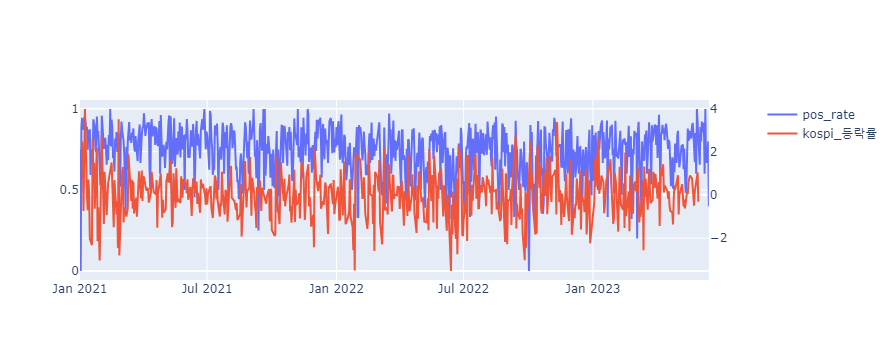

In [36]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=cdf_total.index, y=cdf_total['pos_rate'], mode='lines', name='pos_rate'),secondary_y=False)
fig.add_trace(go.Scatter(x=kospi.index, y=kospi['등락률'], mode='lines', name='kospi_등락률'),secondary_y=True)
fig.show()

* Negative 비율과 KOSPI 등락률
    * KOSPI가 내릴 때, 부정비율이 올라감.

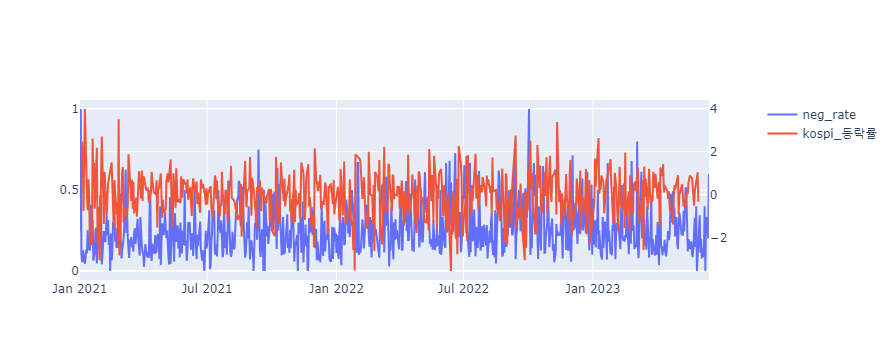

In [37]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=cdf_total.index, y=cdf_total['neg_rate'], mode='lines', name='neg_rate'),secondary_y=False)
fig.add_trace(go.Scatter(x=kospi.index, y=kospi['등락률'], mode='lines', name='kospi_등락률'),secondary_y=True)
fig.show()

* 긍부정 비율과 KOSPI 등락률
    * pos_neg_rate = (pos-neg)/당일 뉴스개수

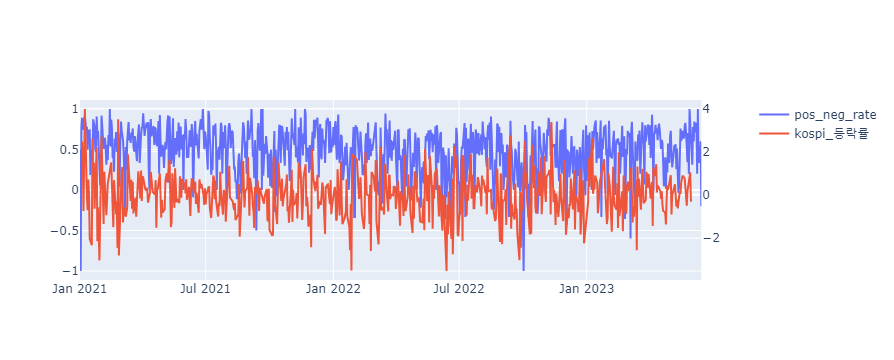

In [38]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=cdf_total.index, y=cdf_total['pos_neg_rate'], mode='lines', name='pos_neg_rate'),secondary_y=False)
fig.add_trace(go.Scatter(x=kospi.index, y=kospi['등락률'], mode='lines', name='kospi_등락률'),secondary_y=True)
fig.show()

* 긍부정 비율 (부정에 weight)과 KOSPI 등락률
    * pos_neg_rate = (pos-(neg*2))/당일 뉴스개수

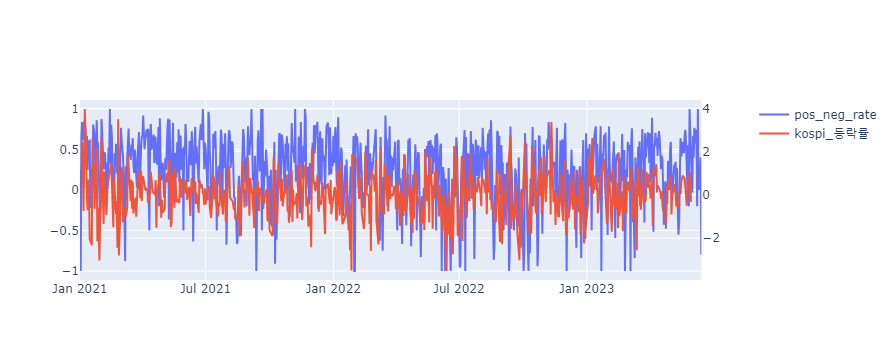

In [39]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=cdf_total.index, y=cdf_total['pos_neg_wrate'], mode='lines', name='pos_neg_rate'),secondary_y=False)
fig.add_trace(go.Scatter(x=kospi.index, y=kospi['등락률'], mode='lines', name='kospi_등락률'),secondary_y=True)
fig.show()

## 상관도 분석

In [40]:
cdf_total2 = pd.merge(cdf_total, kospi[['등락률', 'updown', '등락률_전일', 'updown_전일', '등락률_다음일', 'updown_다음일']], left_index=True, right_index=True, how='outer')
cdf_total2 = cdf_total2.dropna()

#일별 뉴스가 5개이상인 데이터에 대해서만 고려
cdf_total3 = cdf_total2[cdf_total2['label'] > 5]
cdf_total3.head()

pos  neg  label  pos_rate  neg_rate  pos_neg_rate  pos_neg_wrate  \
2021-01-04   70    4     74  0.945946  0.054054      0.891892       0.837838   
2021-01-05   82   12     94  0.872340  0.127660      0.744681       0.617021   
2021-01-06   95   12    107  0.887850  0.112150      0.775701       0.663551   
2021-01-07  126    8    134  0.940299  0.059701      0.880597       0.820896   
2021-01-08  147    7    154  0.954545  0.045455      0.909091       0.863636   

            news_updown   등락률  updown  등락률_전일  updown_전일  등락률_다음일  updown_다음일  
2021-01-04            1  2.47     1.0    0.00        0.0     1.57         1.0  
2021-01-05            1  1.57     1.0    2.47        1.0    -0.75         0.0  
2021-01-06            1 -0.75     0.0    1.57        1.0     2.14         1.0  
2021-01-07            1  2.14     1.0   -0.75        0.0     3.97         1.0  
2021-01-08            1  3.97     1.0    2.14        1.0    -0.12         0.0

* 의외로 등락률은 부정뉴스와 높은 상관관계를 가짐.
    * pos_rate 와 등락률 상관관계 : 0.58
    * neg_rate 와 등락률 상관관계 : -0.58
    * pos_neg_wrate 와 등락률 상관관계: 0.58
    * pos_neg_wrate 와 등락 여부 상관관계: 0.55
    * <font color='red'> 서울경제와 삼성 모두 추가했을 때 correlation은 더 좋아짐.

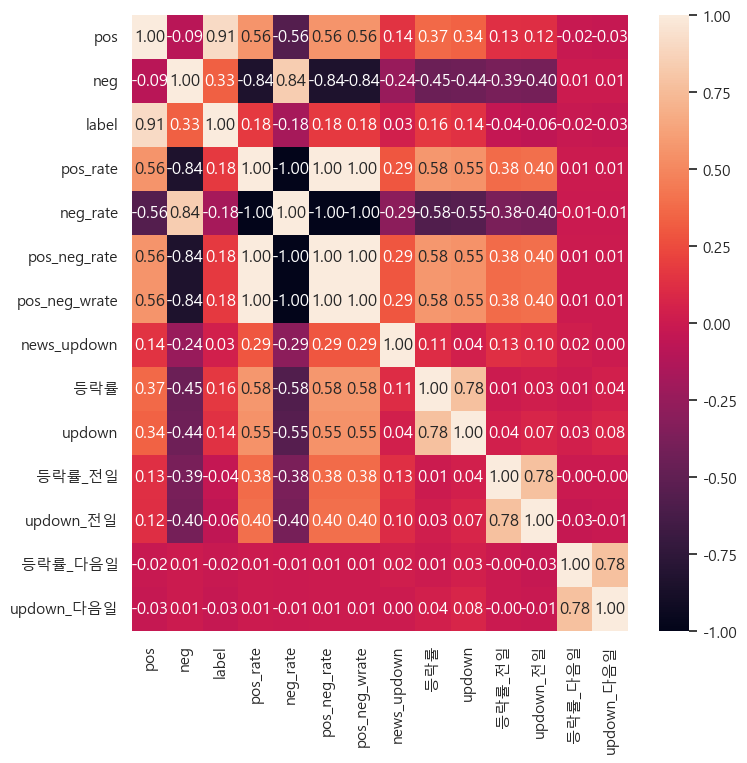

In [41]:
plt.figure(figsize=(8, 8))
sns.heatmap(cdf_total3.corr(), fmt='.2f', annot=True)
plt.show()

## KOSPI가 상승, 하락한 날 기준 긍정 부정 뉴스 
* 전체 데이터 기준 KOSPI 당일과 전날까지 등락 여부에 따라서 영향도가 나타남
    * KOSPI가 올랐을 때, 긍정비율이 높음
    * KOSPI가 내렸을 때, 부정비율이 높음

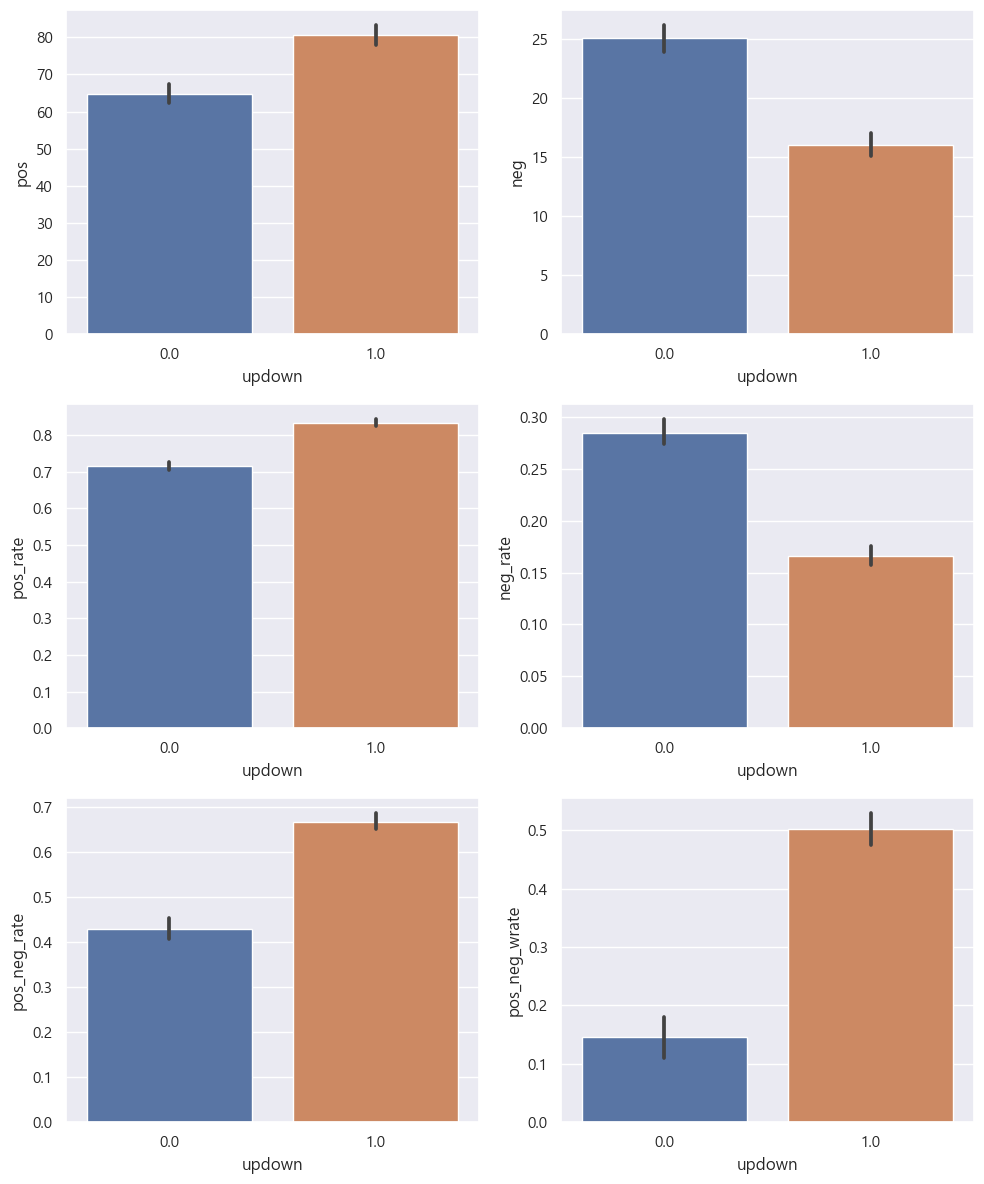

In [42]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
sns.barplot(cdf_total3,x='updown', y='pos', ax=axes[0][0])
sns.barplot(cdf_total3,x='updown', y='neg', ax=axes[0][1])
sns.barplot(cdf_total3,x='updown', y='pos_rate', ax=axes[1][0])
sns.barplot(cdf_total3,x='updown', y='neg_rate', ax=axes[1][1])
sns.barplot(cdf_total3,x='updown', y='pos_neg_rate', ax=axes[2][0])
sns.barplot(cdf_total3,x='updown', y='pos_neg_wrate', ax=axes[2][1])
    
plt.tight_layout()
plt.show()

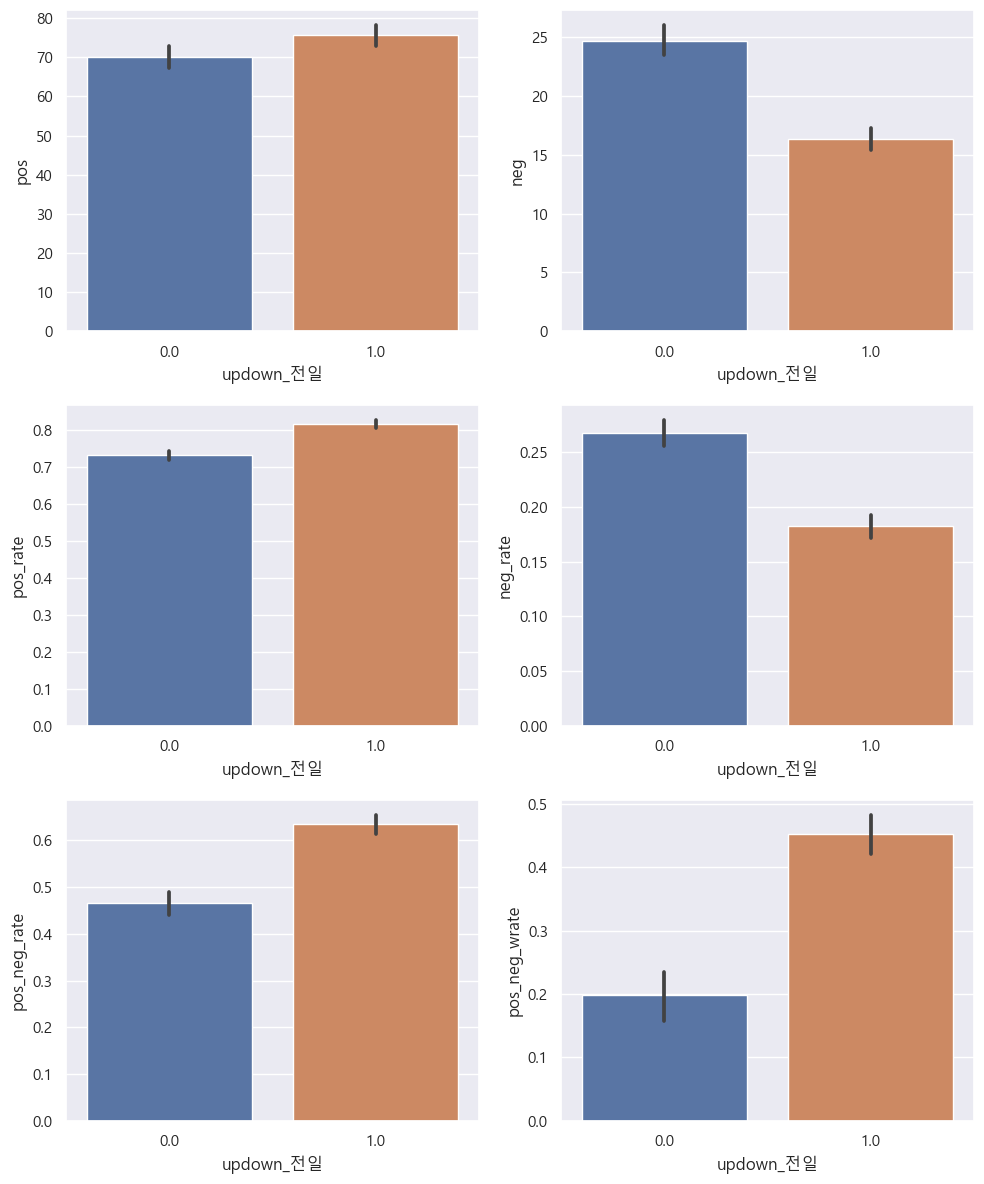

In [43]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
sns.barplot(cdf_total3,x='updown_전일', y='pos', ax=axes[0][0])
sns.barplot(cdf_total3,x='updown_전일', y='neg', ax=axes[0][1])
sns.barplot(cdf_total3,x='updown_전일', y='pos_rate', ax=axes[1][0])
sns.barplot(cdf_total3,x='updown_전일', y='neg_rate', ax=axes[1][1])
sns.barplot(cdf_total3,x='updown_전일', y='pos_neg_rate', ax=axes[2][0])
sns.barplot(cdf_total3,x='updown_전일', y='pos_neg_wrate', ax=axes[2][1])
    
plt.tight_layout()
plt.show()

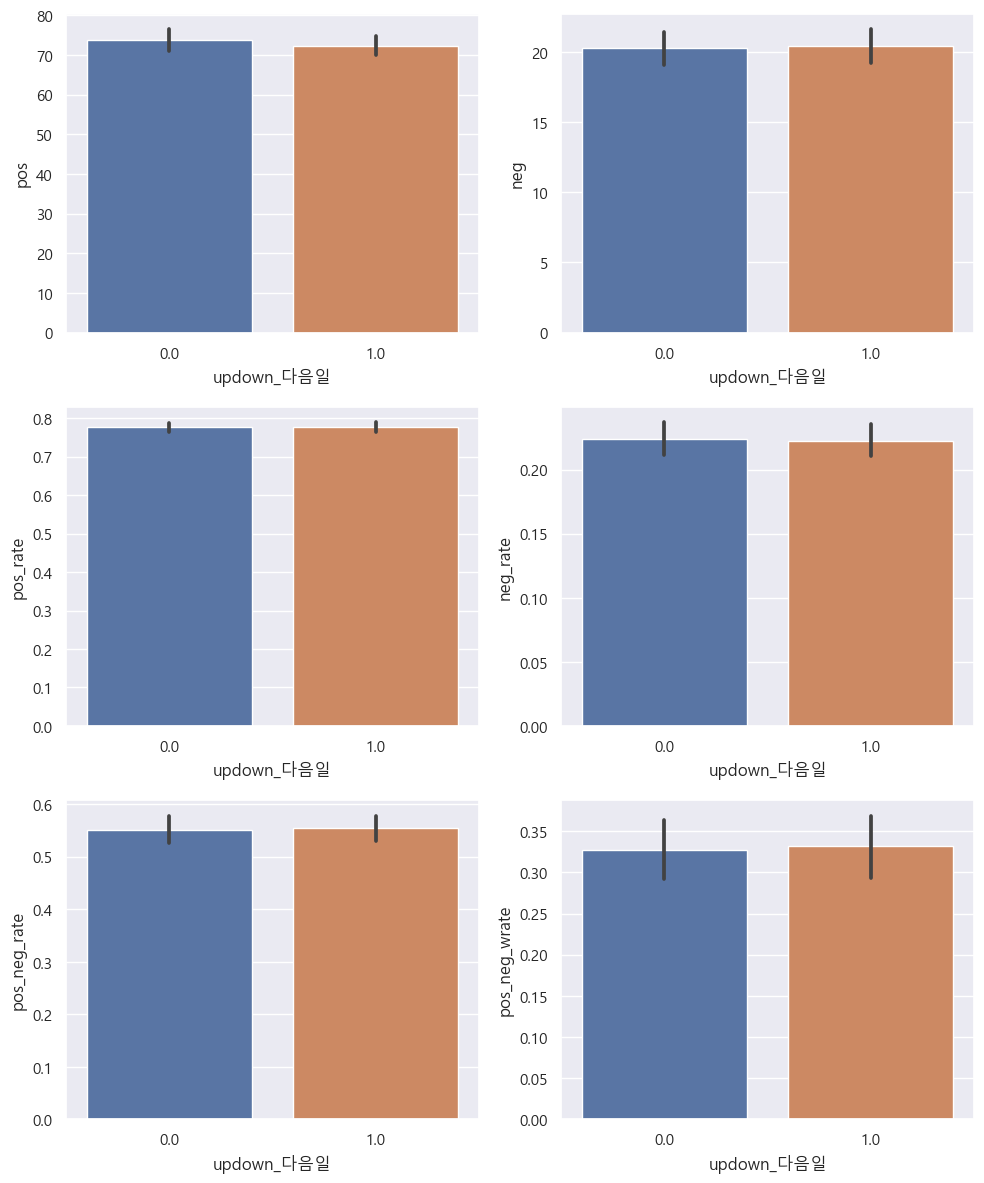

In [44]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
sns.barplot(cdf_total3,x='updown_다음일', y='pos', ax=axes[0][0])
sns.barplot(cdf_total3,x='updown_다음일', y='neg', ax=axes[0][1])
sns.barplot(cdf_total3,x='updown_다음일', y='pos_rate', ax=axes[1][0])
sns.barplot(cdf_total3,x='updown_다음일', y='neg_rate', ax=axes[1][1])
sns.barplot(cdf_total3,x='updown_다음일', y='pos_neg_rate', ax=axes[2][0])
sns.barplot(cdf_total3,x='updown_다음일', y='pos_neg_wrate', ax=axes[2][1])
    
plt.tight_layout()
plt.show()

## T-test
* t값이 작을 수록 유사 그룹임.
    * 즉, t값도 작게, p-value(유의수준)도 작게(0.002이하) 나와야함.
* 상관계수 분석에서 어느정도 유의미한 결과를 보이는 값을 기준으로 시행.

In [45]:
cdf_total2 = pd.merge(cdf_total, kospi[['등락률', '등락률_Scaler', 'updown', '등락률_전일', 'updown_전일', '등락률_다음일', 'updown_다음일']], left_index=True, right_index=True, how='outer')
cdf_total2 = cdf_total2.dropna()

#일별 뉴스가 5개이상인 데이터에 대해서만 고려
cdf_total3 = cdf_total2[cdf_total2['label'] > 5]
cdf_total3.head()

pos  neg  label  pos_rate  neg_rate  pos_neg_rate  pos_neg_wrate  \
2021-01-04   70    4     74  0.945946  0.054054      0.891892       0.837838   
2021-01-05   82   12     94  0.872340  0.127660      0.744681       0.617021   
2021-01-06   95   12    107  0.887850  0.112150      0.775701       0.663551   
2021-01-07  126    8    134  0.940299  0.059701      0.880597       0.820896   
2021-01-08  147    7    154  0.954545  0.045455      0.909091       0.863636   

            news_updown   등락률  등락률_Scaler  updown  등락률_전일  updown_전일  등락률_다음일  \
2021-01-04            1  2.47    2.321052     1.0    0.00        0.0     1.57   
2021-01-05            1  1.57    1.479566     1.0    2.47        1.0    -0.75   
2021-01-06            1 -0.75   -0.689598     0.0    1.57        1.0     2.14   
2021-01-07            1  2.14    2.012507     1.0   -0.75        0.0     3.97   
2021-01-08            1  3.97    3.723528     1.0    2.14        1.0    -0.12   

            updown_다음일  
2021-01-04         1.0  
2021-01-05         0.0  
2021-01-06         1.0  
2021-01-07         1.0  
2021-01-08         0.0

In [46]:
t, pvalue = stats.ttest_ind(cdf_total3['pos_rate'], cdf_total3['등락률_Scaler'])
t, pvalue

(18.83773736864791, 1.752387276204036e-69)

In [47]:
t, pvalue = stats.ttest_ind(cdf_total3['neg_rate'], cdf_total3['등락률_Scaler'])
t, pvalue

(5.41591202997674, 7.372503675627037e-08)

In [48]:
t, pvalue = stats.ttest_ind(cdf_total3['pos_neg_rate'], cdf_total3['등락률_Scaler'], equal_var=True)
t, pvalue

(13.198760456093016, 3.2000357888839016e-37)

In [49]:
t, pvalue = stats.ttest_ind(cdf_total3['pos_neg_wrate'], cdf_total3['등락률_Scaler'], equal_var=True)
t, pvalue

(7.66511965123269, 3.693038083774268e-14)

# 결과 분석 (장중 데이터)

## 시간별 분석

* Positive 비율과 KOSPI 등락률

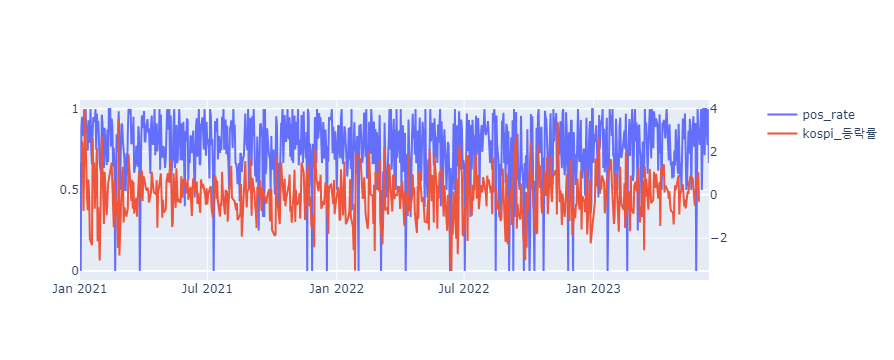

In [50]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=cdf_open.index, y=cdf_open['pos_rate'], mode='lines', name='pos_rate'),secondary_y=False)
fig.add_trace(go.Scatter(x=kospi.index, y=kospi['등락률'], mode='lines', name='kospi_등락률'),secondary_y=True)
fig.show()

* Negative 비율과 KOSPI 등락률

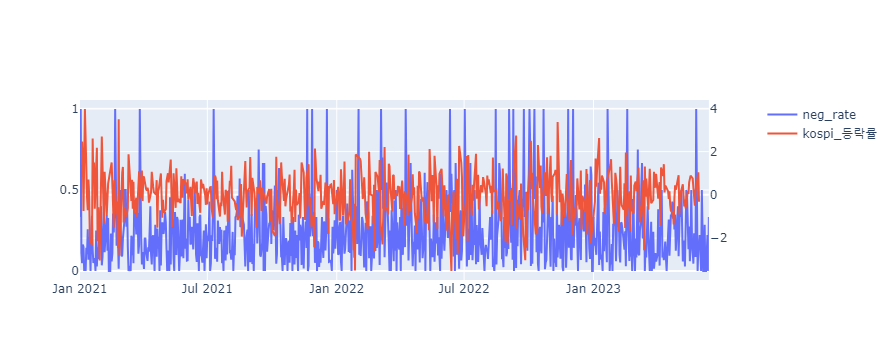

In [51]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=cdf_open.index, y=cdf_open['neg_rate'], mode='lines', name='neg_rate'),secondary_y=False)
fig.add_trace(go.Scatter(x=kospi.index, y=kospi['등락률'], mode='lines', name='kospi_등락률'),secondary_y=True)
fig.show()

* 긍부정 비율과 KOSPI 등락률
    * pos_neg_rate = (pos-neg)/당일 뉴스개수

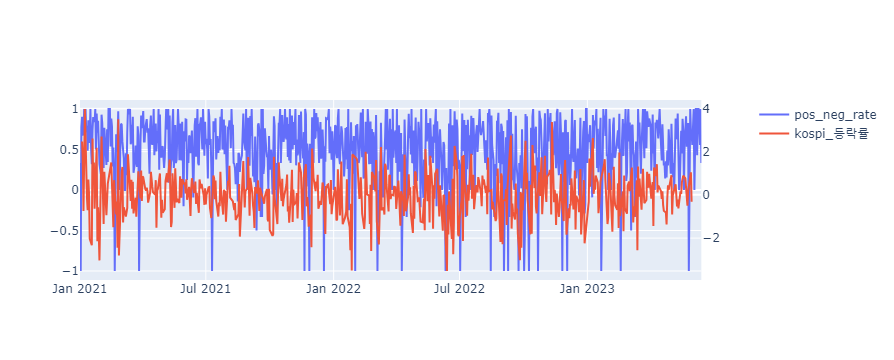

In [52]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=cdf_open.index, y=cdf_open['pos_neg_rate'], mode='lines', name='pos_neg_rate'),secondary_y=False)
fig.add_trace(go.Scatter(x=kospi.index, y=kospi['등락률'], mode='lines', name='kospi_등락률'),secondary_y=True)
fig.show()

* 긍부정 비율 (부정에 weight)과 KOSPI 등락률
    * pos_neg_rate = (pos-(neg*2))/당일 뉴스개수

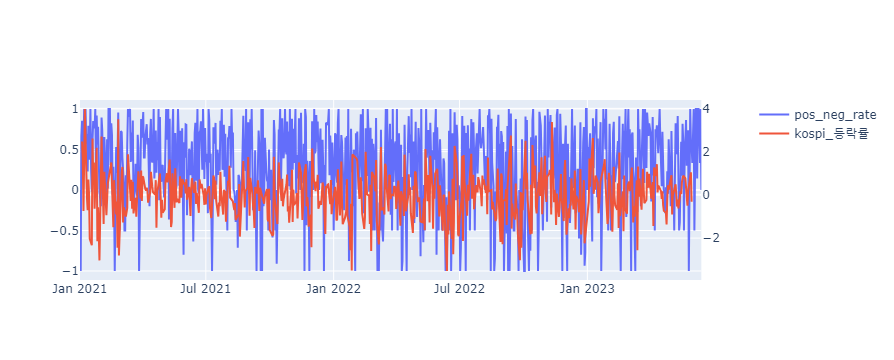

In [53]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=cdf_open.index, y=cdf_open['pos_neg_wrate'], mode='lines', name='pos_neg_rate'),secondary_y=False)
fig.add_trace(go.Scatter(x=kospi.index, y=kospi['등락률'], mode='lines', name='kospi_등락률'),secondary_y=True)
fig.show()

## 상관도 분석

In [54]:
cdf_open2 = pd.merge(cdf_open, kospi[['등락률', 'updown',  '등락률_전일', 'updown_전일', '등락률_다음일', 'updown_다음일']], left_index=True, right_index=True, how='outer')
cdf_open2 = cdf_open2.dropna()

# 일별 뉴스가 5개이상인 데이터에 대해서만 고려
cdf_open3 = cdf_open2[cdf_open2['label'] > 5]

cdf_open3.head()

pos  neg  label  pos_rate  neg_rate  pos_neg_rate  pos_neg_wrate  \
2021-01-04   59    3     62  0.951613  0.048387      0.903226       0.854839   
2021-01-05   36    7     43  0.837209  0.162791      0.674419       0.511628   
2021-01-06   57   10     67  0.850746  0.149254      0.701493       0.552239   
2021-01-07  100    0    100  1.000000  0.000000      1.000000       1.000000   
2021-01-08   94    4     98  0.959184  0.040816      0.918367       0.877551   

            news_updown   등락률  updown  등락률_전일  updown_전일  등락률_다음일  updown_다음일  
2021-01-04            1  2.47     1.0    0.00        0.0     1.57         1.0  
2021-01-05            1  1.57     1.0    2.47        1.0    -0.75         0.0  
2021-01-06            1 -0.75     0.0    1.57        1.0     2.14         1.0  
2021-01-07            1  2.14     1.0   -0.75        0.0     3.97         1.0  
2021-01-08            1  3.97     1.0    2.14        1.0    -0.12         0.0

* 의외로 등락률은 부정뉴스와 높은 상관관계를 가짐.
    * pos_rate 와 등락률 상관관계 : -0.73
    * neg_rate 와 등락률 상관관계 : -0.73
    * pos_neg_wrate 와 등락률 상관관계: 0.73
    * pos_neg_wrate 와 등락여부와 상관관계: 0.68
    * <font color='red'> 서울경제, 삼성 뉴스 추가했을 때 correlation은 더 좋아짐.

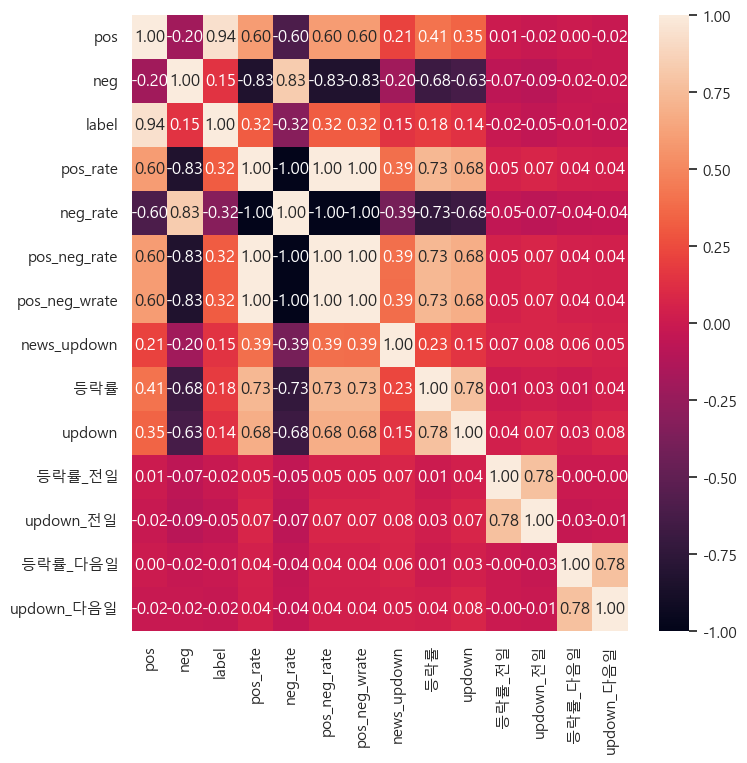

In [55]:
plt.figure(figsize=(8, 8))
sns.heatmap(cdf_open3.corr(), fmt='.2f', annot=True)
plt.show()

## KOSPI가 상승, 하락한 날 기준 긍정 부정 뉴스 
* 장중 뉴스는 딱 그 당일 KOSPI와만 연관성이 존재
    * KOSPI가 올랐을 때, 긍정비율이 높음
    * KOSPI가 내렸을 때, 부정비율이 높음

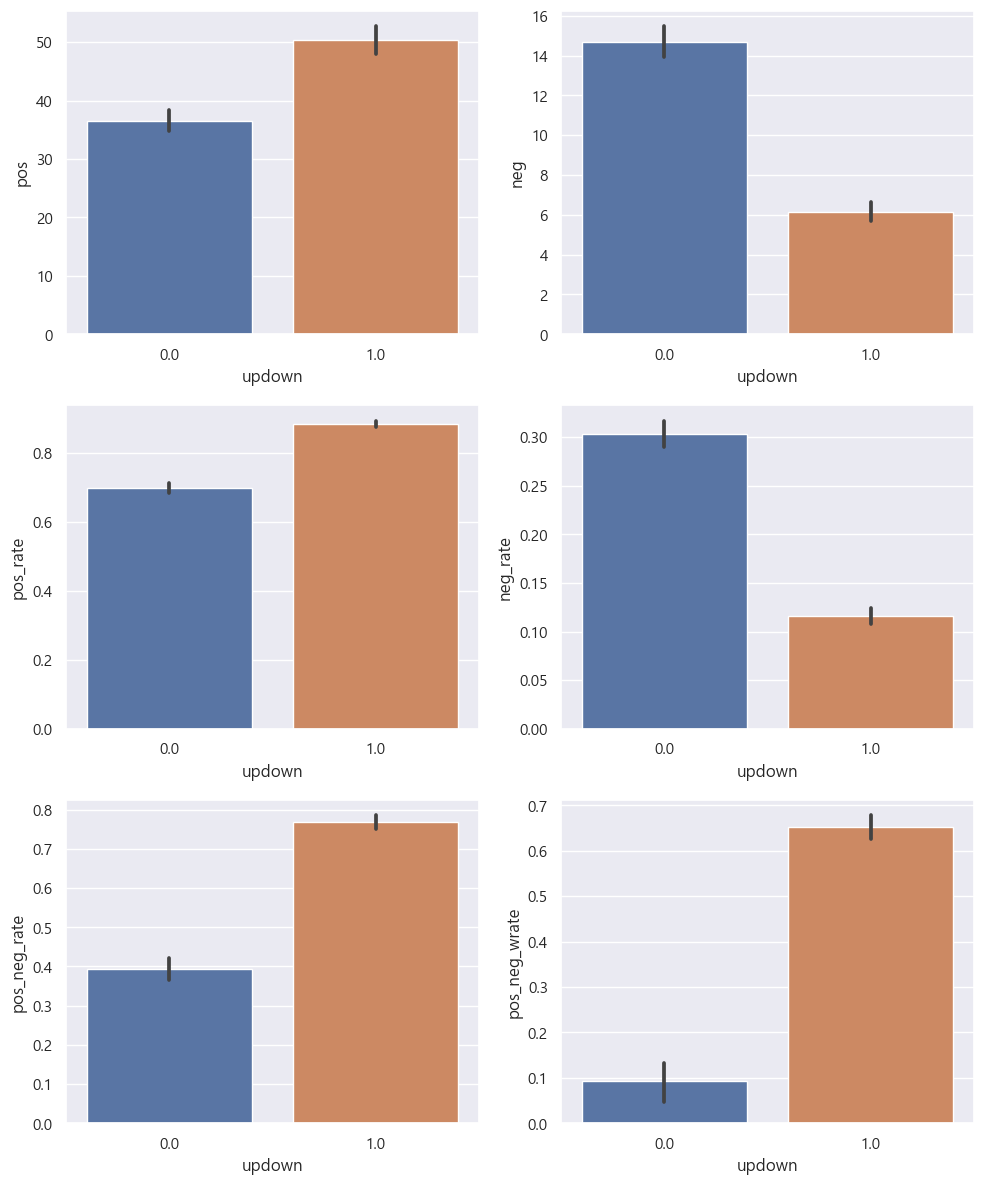

In [56]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
sns.barplot(cdf_open3,x='updown', y='pos', ax=axes[0][0])
sns.barplot(cdf_open3,x='updown', y='neg', ax=axes[0][1])
sns.barplot(cdf_open3,x='updown', y='pos_rate', ax=axes[1][0])
sns.barplot(cdf_open3,x='updown', y='neg_rate', ax=axes[1][1])
sns.barplot(cdf_open3,x='updown', y='pos_neg_rate', ax=axes[2][0])
sns.barplot(cdf_open3,x='updown', y='pos_neg_wrate', ax=axes[2][1])
    
plt.tight_layout()
plt.show()

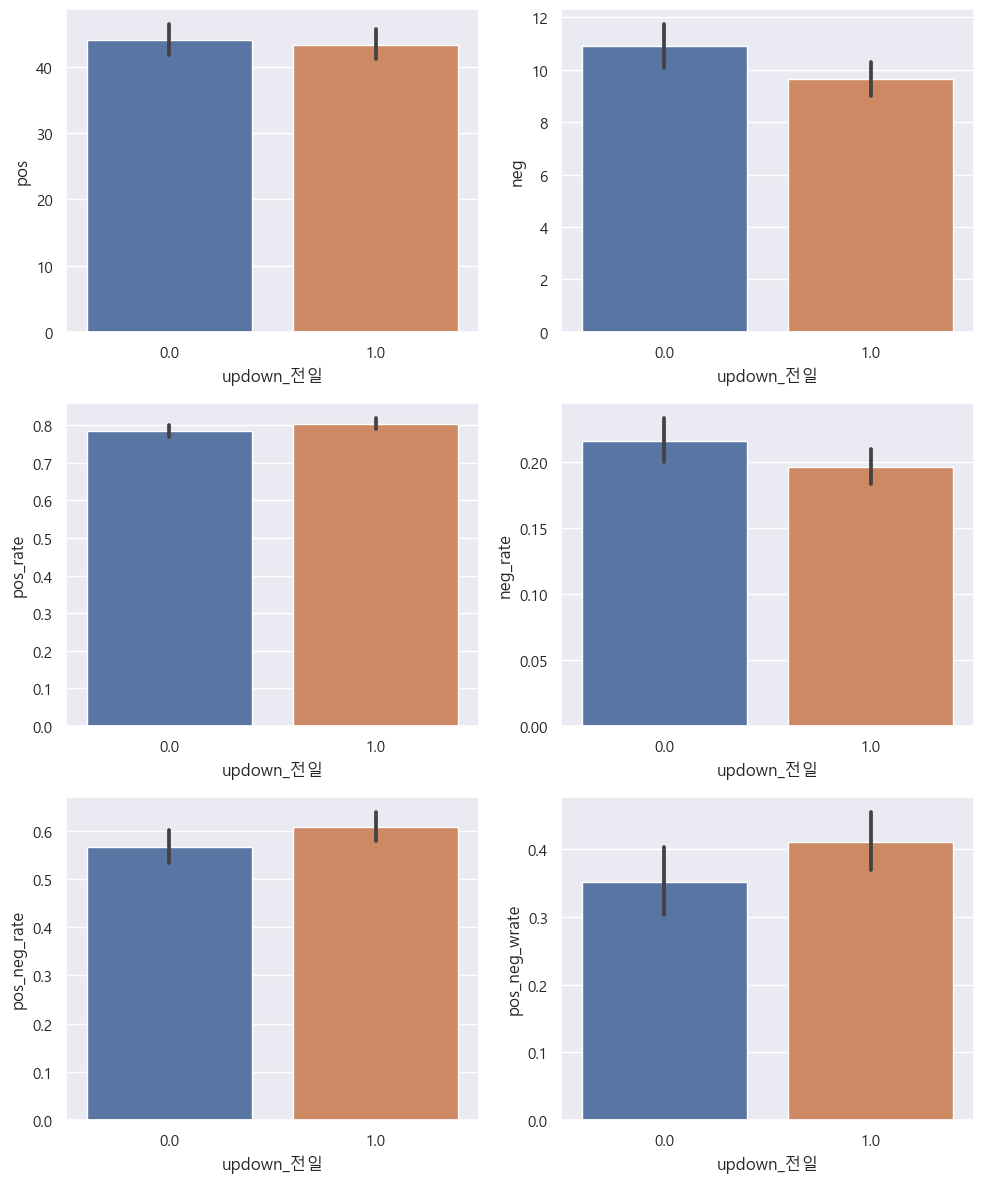

In [57]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
sns.barplot(cdf_open3,x='updown_전일', y='pos', ax=axes[0][0])
sns.barplot(cdf_open3,x='updown_전일', y='neg', ax=axes[0][1])
sns.barplot(cdf_open3,x='updown_전일', y='pos_rate', ax=axes[1][0])
sns.barplot(cdf_open3,x='updown_전일', y='neg_rate', ax=axes[1][1])
sns.barplot(cdf_open3,x='updown_전일', y='pos_neg_rate', ax=axes[2][0])
sns.barplot(cdf_open3,x='updown_전일', y='pos_neg_wrate', ax=axes[2][1])
    
plt.tight_layout()
plt.show()

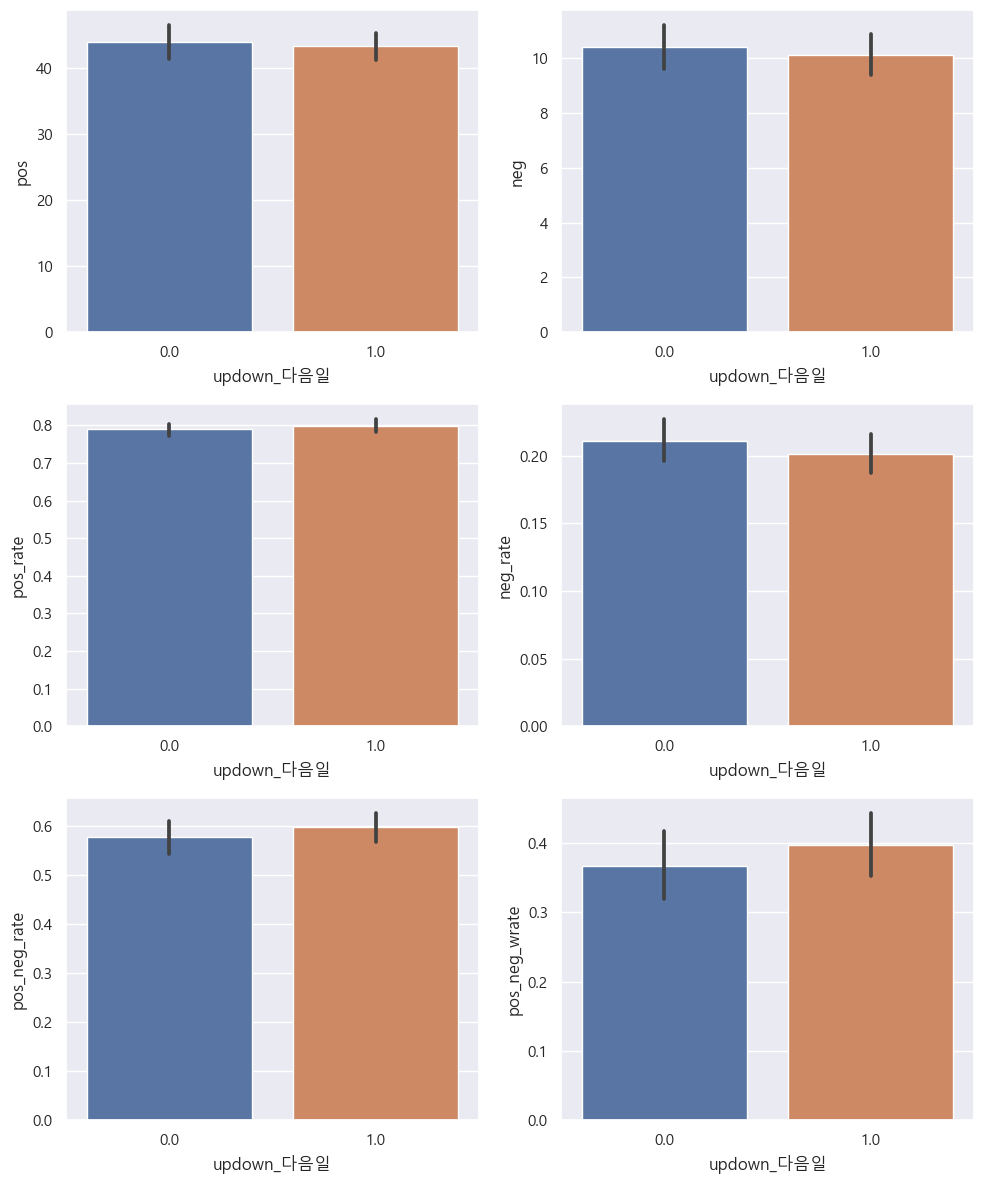

In [58]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
sns.barplot(cdf_open3,x='updown_다음일', y='pos', ax=axes[0][0])
sns.barplot(cdf_open3,x='updown_다음일', y='neg', ax=axes[0][1])
sns.barplot(cdf_open3,x='updown_다음일', y='pos_rate', ax=axes[1][0])
sns.barplot(cdf_open3,x='updown_다음일', y='neg_rate', ax=axes[1][1])
sns.barplot(cdf_open3,x='updown_다음일', y='pos_neg_rate', ax=axes[2][0])
sns.barplot(cdf_open3,x='updown_다음일', y='pos_neg_wrate', ax=axes[2][1])
    
plt.tight_layout()
plt.show()

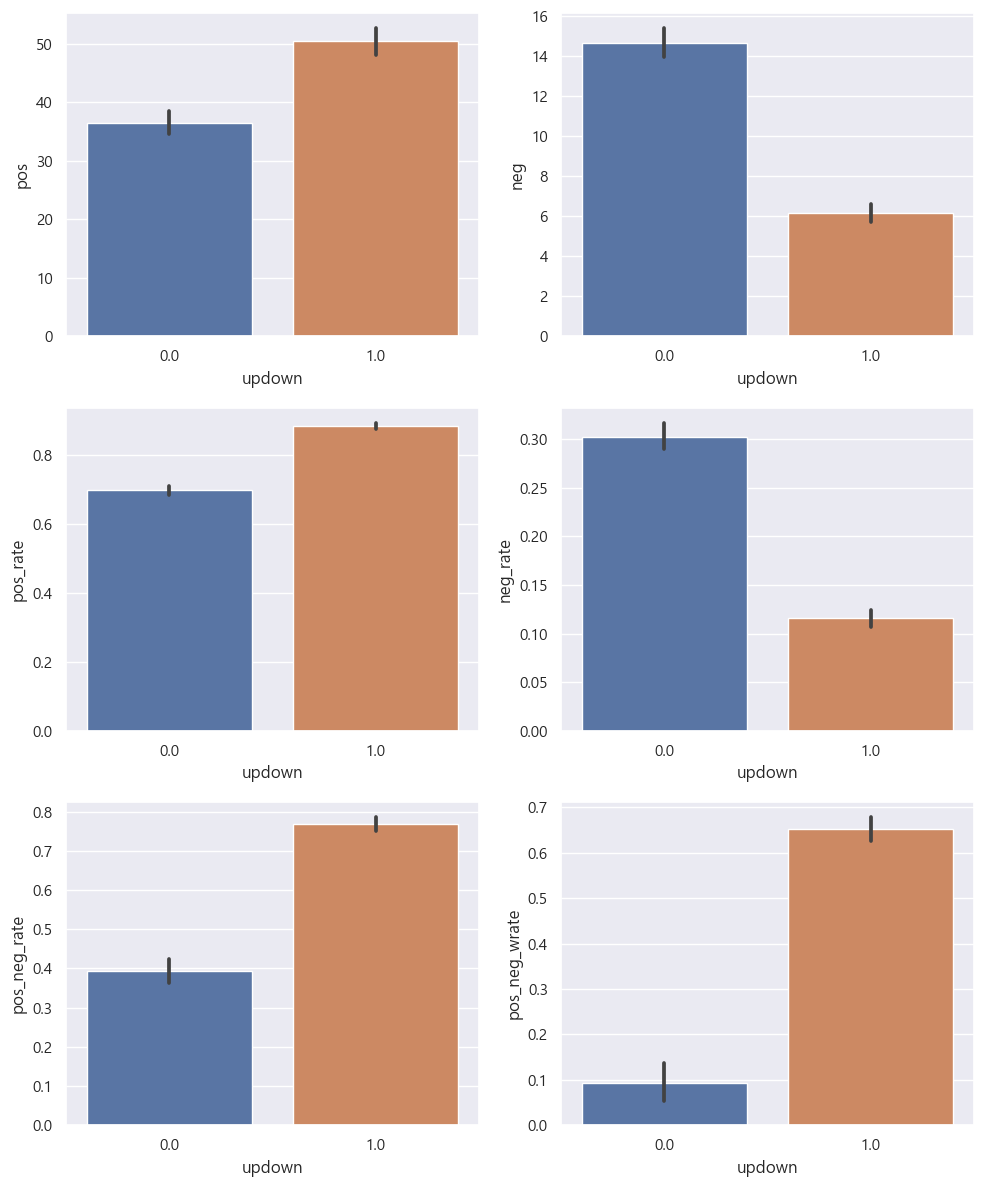

In [59]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
sns.barplot(cdf_open3,x='updown', y='pos', ax=axes[0][0])
sns.barplot(cdf_open3,x='updown', y='neg', ax=axes[0][1])
sns.barplot(cdf_open3,x='updown', y='pos_rate', ax=axes[1][0])
sns.barplot(cdf_open3,x='updown', y='neg_rate', ax=axes[1][1])
sns.barplot(cdf_open3,x='updown', y='pos_neg_rate', ax=axes[2][0])
sns.barplot(cdf_open3,x='updown', y='pos_neg_wrate', ax=axes[2][1])
    
plt.tight_layout()
plt.show()

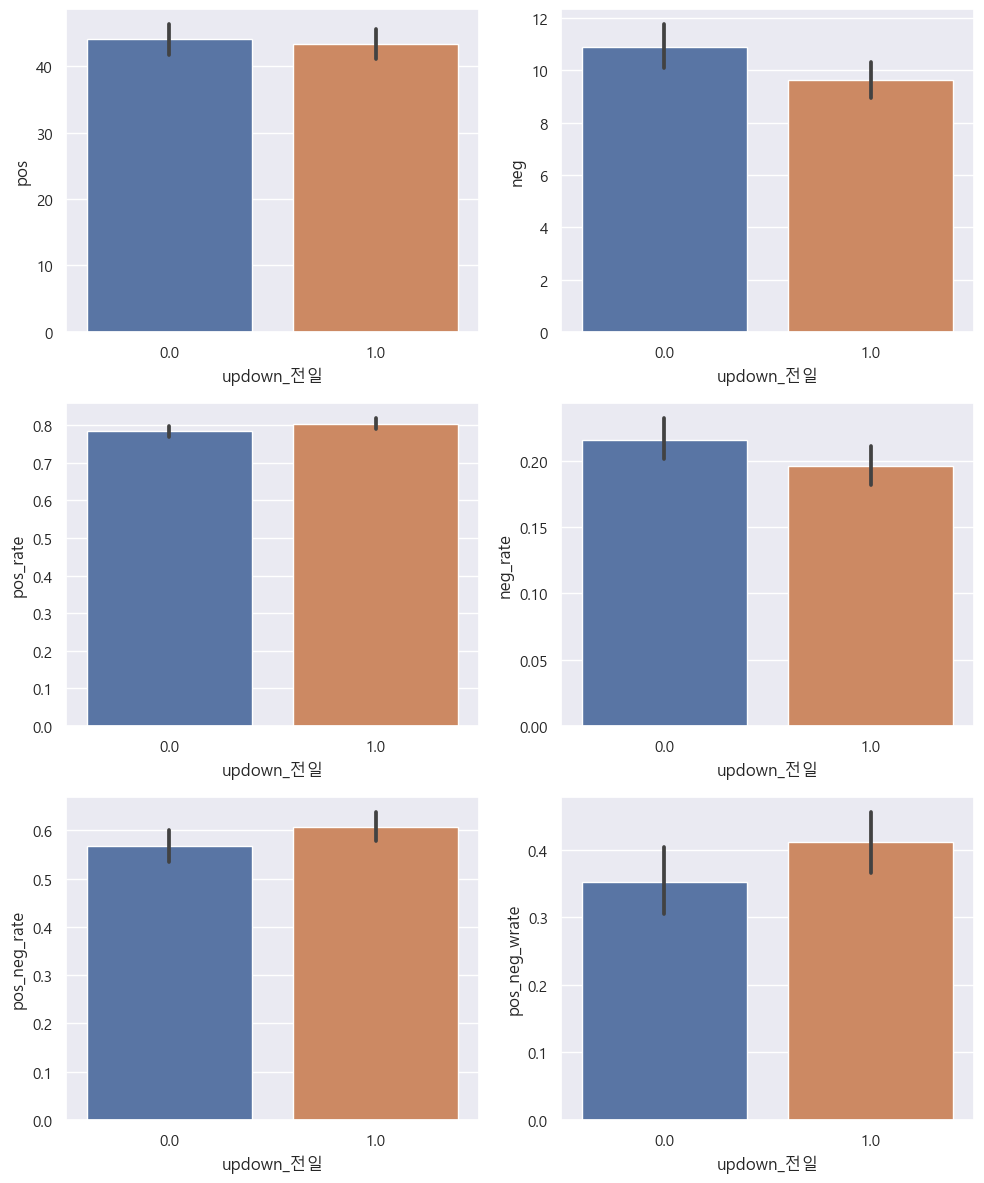

In [60]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
sns.barplot(cdf_open3,x='updown_전일', y='pos', ax=axes[0][0])
sns.barplot(cdf_open3,x='updown_전일', y='neg', ax=axes[0][1])
sns.barplot(cdf_open3,x='updown_전일', y='pos_rate', ax=axes[1][0])
sns.barplot(cdf_open3,x='updown_전일', y='neg_rate', ax=axes[1][1])
sns.barplot(cdf_open3,x='updown_전일', y='pos_neg_rate', ax=axes[2][0])
sns.barplot(cdf_open3,x='updown_전일', y='pos_neg_wrate', ax=axes[2][1])
    
plt.tight_layout()
plt.show()

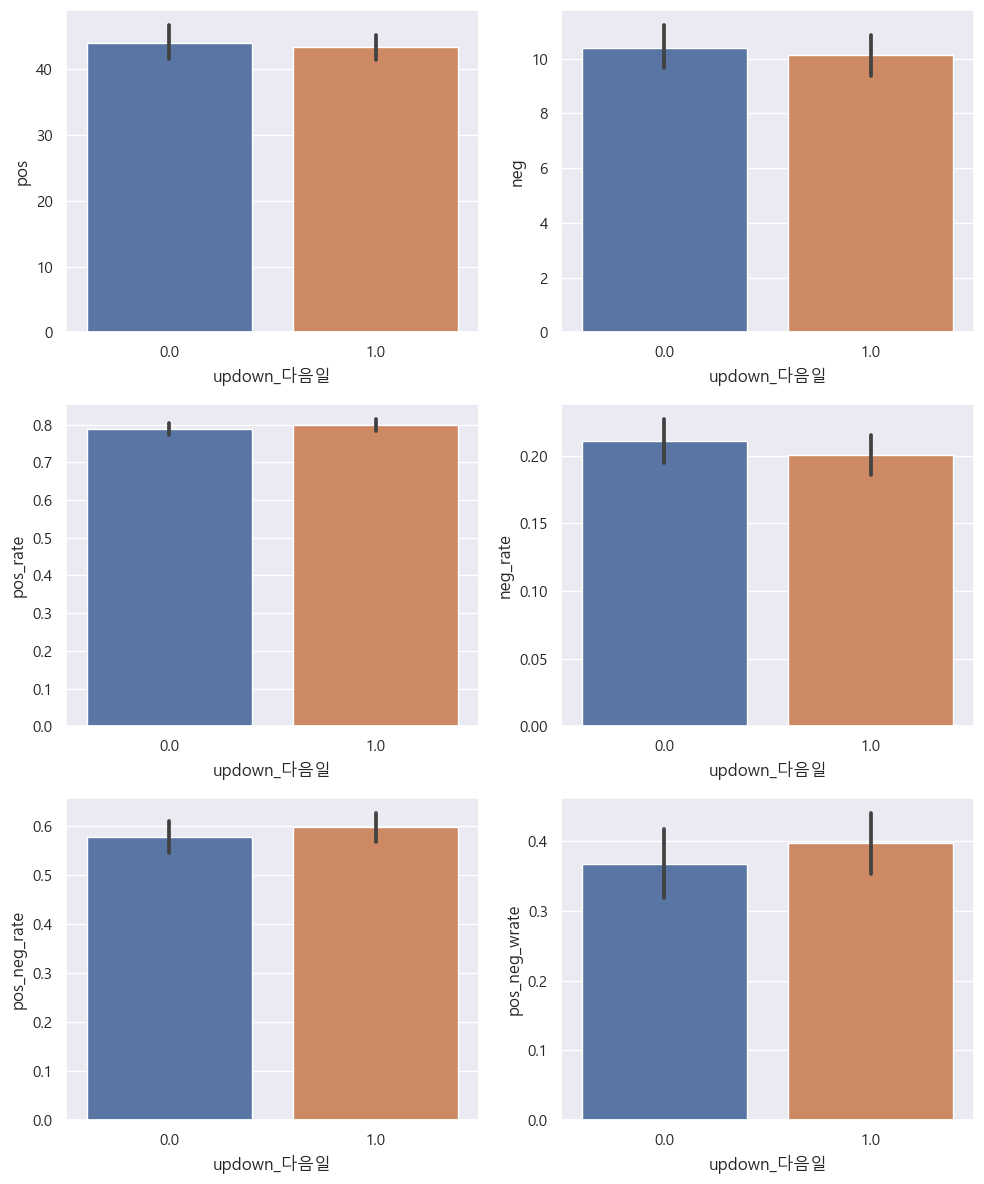

In [61]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
sns.barplot(cdf_open3,x='updown_다음일', y='pos', ax=axes[0][0])
sns.barplot(cdf_open3,x='updown_다음일', y='neg', ax=axes[0][1])
sns.barplot(cdf_open3,x='updown_다음일', y='pos_rate', ax=axes[1][0])
sns.barplot(cdf_open3,x='updown_다음일', y='neg_rate', ax=axes[1][1])
sns.barplot(cdf_open3,x='updown_다음일', y='pos_neg_rate', ax=axes[2][0])
sns.barplot(cdf_open3,x='updown_다음일', y='pos_neg_wrate', ax=axes[2][1])
    
plt.tight_layout()
plt.show()

## T-test
* t값이 작을 수록 유사 그룹임.
    * 즉, t값도 작게, p-value(유의수준)도 작게(0.002이하) 나와야함.
* 상관계수 분석에서 어느정도 유의미한 결과를 보이는 값을 기준으로 시행.

In [62]:
cdf_open2 = pd.merge(cdf_open, kospi[['등락률', '등락률_Scaler', 'updown',  '등락률_전일', 'updown_전일', '등락률_다음일', 'updown_다음일']], left_index=True, right_index=True, how='outer')
cdf_open2 = cdf_open2.dropna()

# 일별 뉴스가 5개이상인 데이터에 대해서만 고려
cdf_open3 = cdf_open2[cdf_open2['label'] > 5]

cdf_open3.head()

pos  neg  label  pos_rate  neg_rate  pos_neg_rate  pos_neg_wrate  \
2021-01-04   59    3     62  0.951613  0.048387      0.903226       0.854839   
2021-01-05   36    7     43  0.837209  0.162791      0.674419       0.511628   
2021-01-06   57   10     67  0.850746  0.149254      0.701493       0.552239   
2021-01-07  100    0    100  1.000000  0.000000      1.000000       1.000000   
2021-01-08   94    4     98  0.959184  0.040816      0.918367       0.877551   

            news_updown   등락률  등락률_Scaler  updown  등락률_전일  updown_전일  등락률_다음일  \
2021-01-04            1  2.47    2.321052     1.0    0.00        0.0     1.57   
2021-01-05            1  1.57    1.479566     1.0    2.47        1.0    -0.75   
2021-01-06            1 -0.75   -0.689598     0.0    1.57        1.0     2.14   
2021-01-07            1  2.14    2.012507     1.0   -0.75        0.0     3.97   
2021-01-08            1  3.97    3.723528     1.0    2.14        1.0    -0.12   

            updown_다음일  
2021-01-04         1.0  
2021-01-05         0.0  
2021-01-06         1.0  
2021-01-07         1.0  
2021-01-08         0.0

In [63]:
t, pvalue = stats.ttest_ind(cdf_open3['pos_rate'], cdf_open3['등락률_Scaler'])
t, pvalue

(19.19292789115937, 9.72298042528691e-72)

In [64]:
t, pvalue = stats.ttest_ind(cdf_open3['neg_rate'], cdf_open3['등락률_Scaler'])
t, pvalue

(4.973248851389847, 7.549884934864951e-07)

In [65]:
t, pvalue = stats.ttest_ind(cdf_open3['pos_neg_rate'], cdf_open3['등락률_Scaler'])
t, pvalue

(13.841166921460118, 1.6517638223457398e-40)

In [66]:
t, pvalue = stats.ttest_ind(cdf_open3['pos_neg_wrate'], cdf_open3['등락률_Scaler'])
t, pvalue

(8.63599423707381, 1.8425211555774786e-17)

# 결과 분석 (장마감 데이터)

## 시간별 분석

* Positive 비율과 KOSPI 등락률

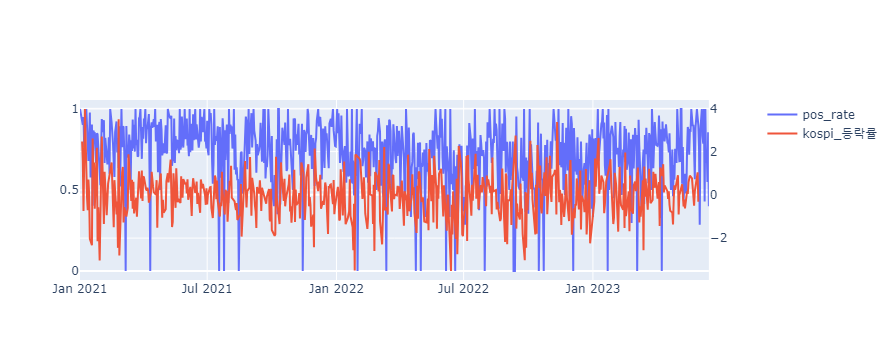

In [67]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=cdf_close.index, y=cdf_close['pos_rate'], mode='lines', name='pos_rate'),secondary_y=False)
fig.add_trace(go.Scatter(x=kospi.index, y=kospi['등락률'], mode='lines', name='kospi_등락률'),secondary_y=True)
fig.show()

* Negative 비율과 KOSPI 등락률

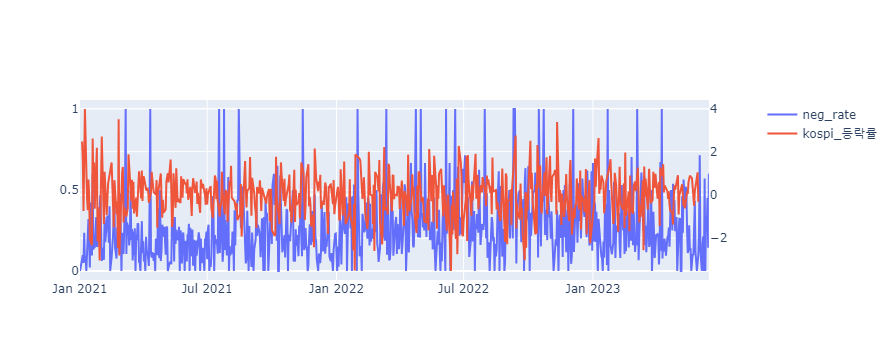

In [68]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=cdf_close.index, y=cdf_close['neg_rate'], mode='lines', name='neg_rate'),secondary_y=False)
fig.add_trace(go.Scatter(x=kospi.index, y=kospi['등락률'], mode='lines', name='kospi_등락률'),secondary_y=True)
fig.show()

* 긍부정 비율과 KOSPI 등락률
    * pos_neg_rate = (pos-neg)/당일 뉴스개수
    * 뉴스가 KOSPI를 후행하는 듯 보임

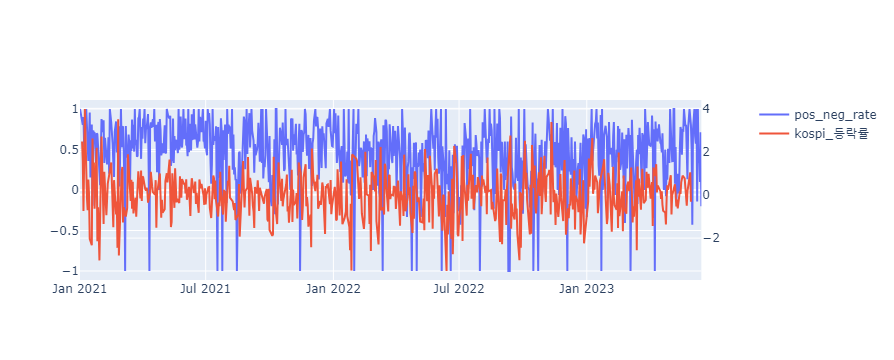

In [69]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=cdf_close.index, y=cdf_close['pos_neg_rate'], mode='lines', name='pos_neg_rate'),secondary_y=False)
fig.add_trace(go.Scatter(x=kospi.index, y=kospi['등락률'], mode='lines', name='kospi_등락률'),secondary_y=True)
fig.show()

* 긍부정 비율 (부정에 weight)과 KOSPI 등락률
    * pos_neg_rate = (pos-(neg*2))/당일 뉴스개수

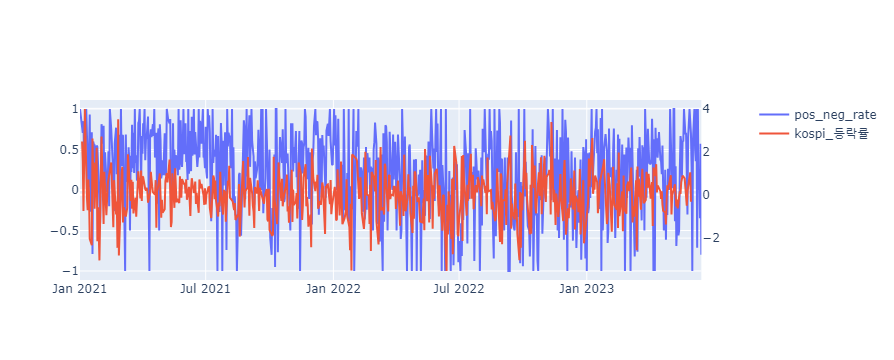

In [70]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=cdf_close.index, y=cdf_close['pos_neg_wrate'], mode='lines', name='pos_neg_rate'),secondary_y=False)
fig.add_trace(go.Scatter(x=kospi.index, y=kospi['등락률'], mode='lines', name='kospi_등락률'),secondary_y=True)
fig.show()

## 상관도 분석

In [71]:
cdf_close2 = pd.merge(cdf_close, kospi[['등락률', 'updown', '등락률_전일', 'updown_전일', '등락률_다음일', 'updown_다음일']], left_index=True, right_index=True, how='outer')
cdf_close2 = cdf_close2.dropna()

# 일별 뉴스가 5개이상인 데이터에 대해서만 고려
cdf_close3 = cdf_close2[cdf_close2['label'] > 5]

cdf_close3.head()

pos  neg  label  pos_rate  neg_rate  pos_neg_rate  pos_neg_wrate  \
2021-01-04   11    1     12  0.916667  0.083333      0.833333       0.750000   
2021-01-05   46    5     51  0.901961  0.098039      0.803922       0.705882   
2021-01-06   38    2     40  0.950000  0.050000      0.900000       0.850000   
2021-01-07   26    8     34  0.764706  0.235294      0.529412       0.294118   
2021-01-08   53    3     56  0.946429  0.053571      0.892857       0.839286   

            news_updown   등락률  updown  등락률_전일  updown_전일  등락률_다음일  updown_다음일  
2021-01-04            1  2.47     1.0    0.00        0.0     1.57         1.0  
2021-01-05            1  1.57     1.0    2.47        1.0    -0.75         0.0  
2021-01-06            1 -0.75     0.0    1.57        1.0     2.14         1.0  
2021-01-07            1  2.14     1.0   -0.75        0.0     3.97         1.0  
2021-01-08            1  3.97     1.0    2.14        1.0    -0.12         0.0

* 장외 뉴스는 당일 KOSPI와 연관성이 적음
    * pos_neg_wrate와 등락률 상관관계 : 0.07
    * pos_neg_wrate 와 등락여부와 상관관계: 0.12
* 장외 뉴스는 전일 KOSPI와 연관성이 있음 (뉴스가 KOSPI의 후행지수임을 나타냄.)
    * pos_neg_wrate 와 전일 등락률 상관관계: 0.56
    * pos_neg_wrate 와 전일 등락 여부 상관관계: 0.6

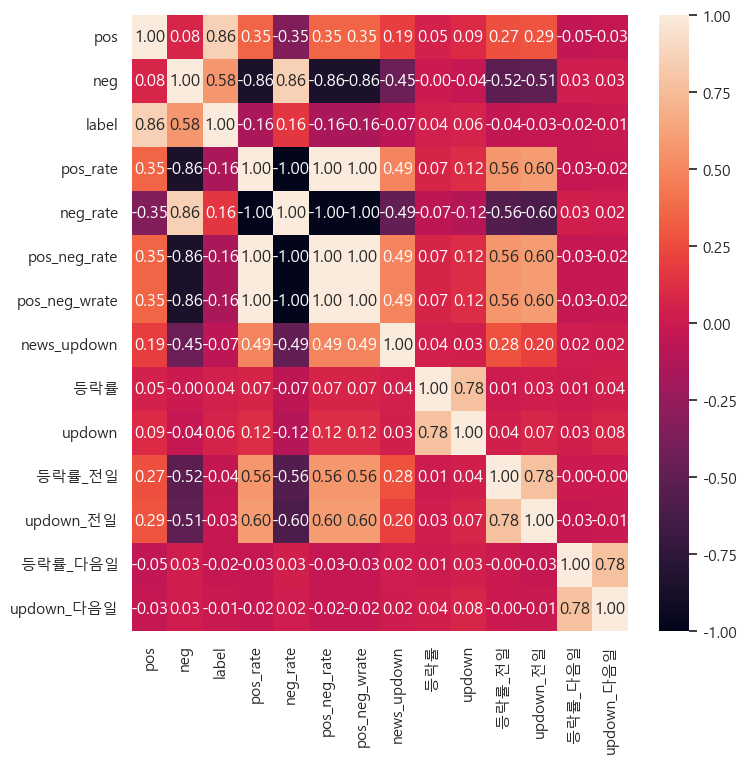

In [72]:
plt.figure(figsize=(8, 8))
sns.heatmap(cdf_close3.corr(), fmt='.2f', annot=True)
plt.show()

## KOSPI가 상승, 하락한 날 기준 긍정 부정 뉴스 
* 장마감후 뉴스의 경우는 장마감일 즉, 이전 KOSPI와 연관성이 가장 크고, 
* 뉴스가 나온 뒤, 시작하는 장까지도 어느정도 연관성이 존재함.
    * KOSPI가 올랐을 때, 긍정비율이 높음
    * KOSPI가 내렸을 때, 부정비율이 높음

* 아래 결과는 주식장이 시작하기전에 나온 뉴스가 당일 주식장에 미치는 영향을 나타냄
* 이 결과가 연관성을 보인다는 것은 뉴스 긍부정을 단기간이나마 선행지표로 사용할 수 있음을 나타냄.

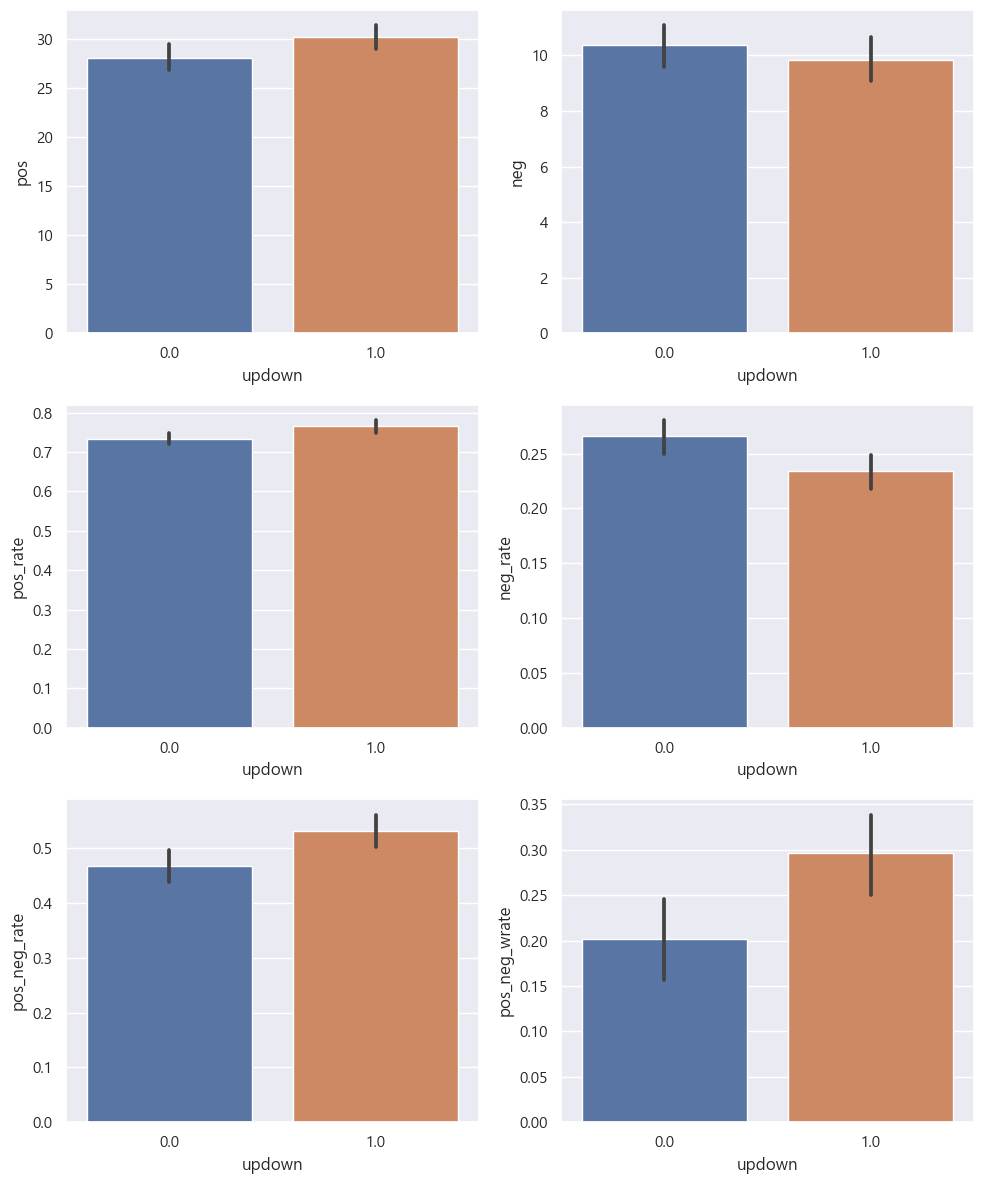

In [73]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
sns.barplot(cdf_close3,x='updown', y='pos', ax=axes[0][0])
sns.barplot(cdf_close3,x='updown', y='neg', ax=axes[0][1])
sns.barplot(cdf_close3,x='updown', y='pos_rate', ax=axes[1][0])
sns.barplot(cdf_close3,x='updown', y='neg_rate', ax=axes[1][1])
sns.barplot(cdf_close3,x='updown', y='pos_neg_rate', ax=axes[2][0])
sns.barplot(cdf_close3,x='updown', y='pos_neg_wrate', ax=axes[2][1])
    
plt.tight_layout()
plt.show()

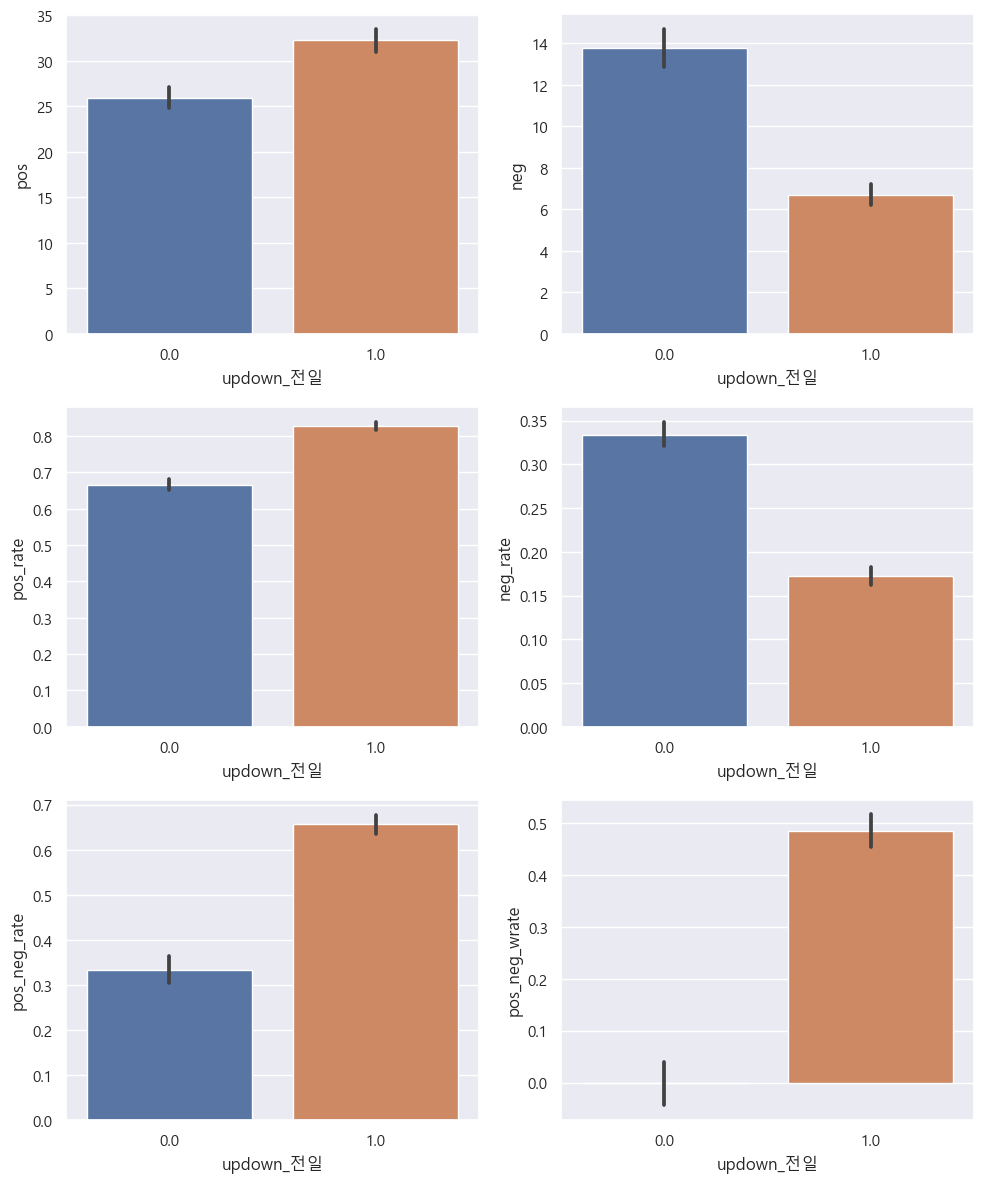

In [74]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
sns.barplot(cdf_close3,x='updown_전일', y='pos', ax=axes[0][0])
sns.barplot(cdf_close3,x='updown_전일', y='neg', ax=axes[0][1])
sns.barplot(cdf_close3,x='updown_전일', y='pos_rate', ax=axes[1][0])
sns.barplot(cdf_close3,x='updown_전일', y='neg_rate', ax=axes[1][1])
sns.barplot(cdf_close3,x='updown_전일', y='pos_neg_rate', ax=axes[2][0])
sns.barplot(cdf_close3,x='updown_전일', y='pos_neg_wrate', ax=axes[2][1])
    
plt.tight_layout()
plt.show()

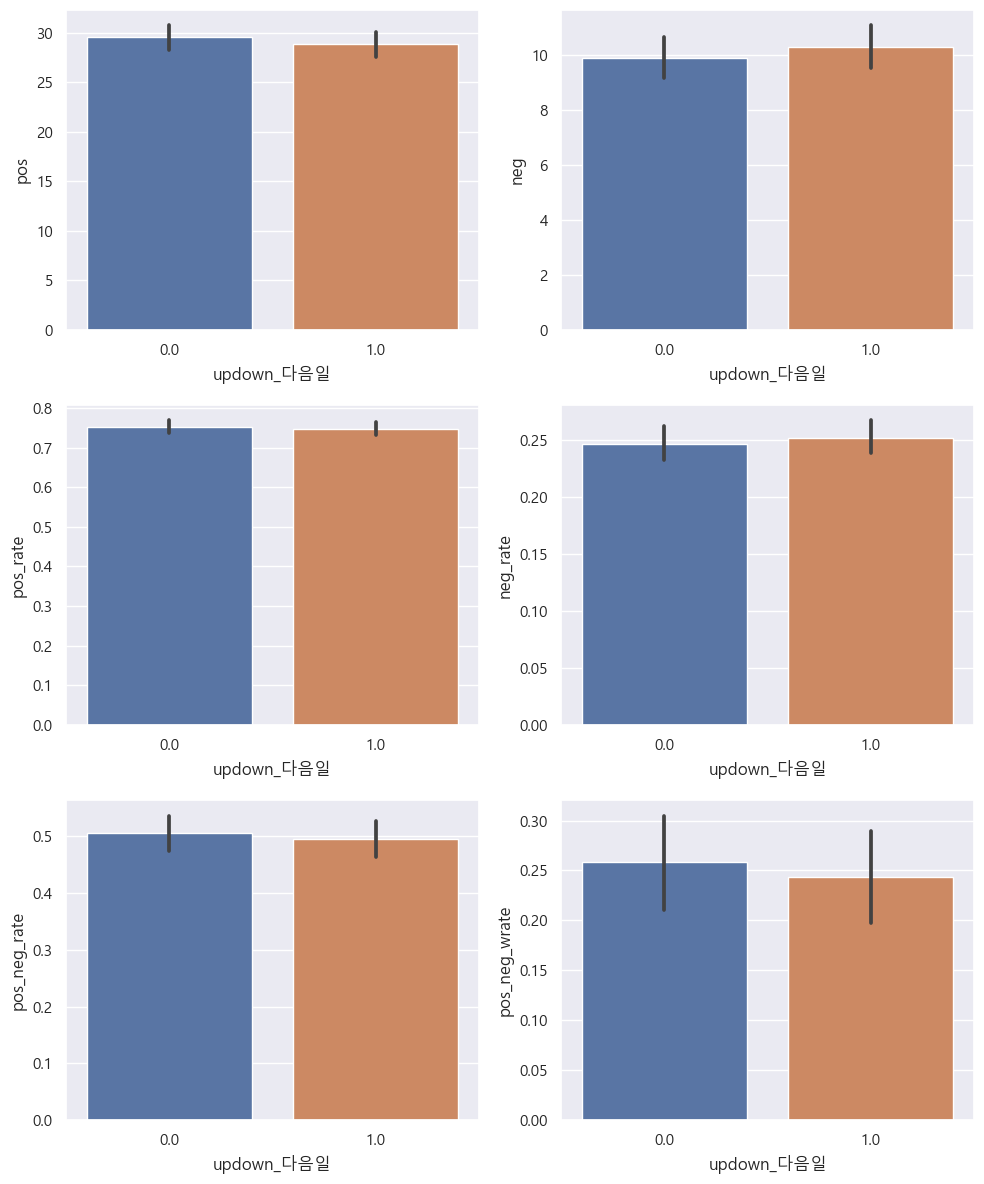

In [75]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
sns.barplot(cdf_close3,x='updown_다음일', y='pos', ax=axes[0][0])
sns.barplot(cdf_close3,x='updown_다음일', y='neg', ax=axes[0][1])
sns.barplot(cdf_close3,x='updown_다음일', y='pos_rate', ax=axes[1][0])
sns.barplot(cdf_close3,x='updown_다음일', y='neg_rate', ax=axes[1][1])
sns.barplot(cdf_close3,x='updown_다음일', y='pos_neg_rate', ax=axes[2][0])
sns.barplot(cdf_close3,x='updown_다음일', y='pos_neg_wrate', ax=axes[2][1])
    
plt.tight_layout()
plt.show()

## T-test
* t값이 작을 수록 유사 그룹임.
    * 즉, t값도 작게, p-value(유의수준)도 작게(0.002이하) 나와야함.
* 상관계수 분석에서 어느정도 유의미한 결과를 보이는 값을 기준으로 시행.

In [76]:
cdf_close2 = pd.merge(cdf_close, kospi[['등락률', '등락률_Scaler', 'updown', '등락률_전일', 'updown_전일', '등락률_다음일', 'updown_다음일']], left_index=True, right_index=True, how='outer')
cdf_close2 = cdf_close2.dropna()

# 일별 뉴스가 5개이상인 데이터에 대해서만 고려
cdf_close3 = cdf_close2[cdf_close2['label'] > 5]

cdf_close3.head()

pos  neg  label  pos_rate  neg_rate  pos_neg_rate  pos_neg_wrate  \
2021-01-04   11    1     12  0.916667  0.083333      0.833333       0.750000   
2021-01-05   46    5     51  0.901961  0.098039      0.803922       0.705882   
2021-01-06   38    2     40  0.950000  0.050000      0.900000       0.850000   
2021-01-07   26    8     34  0.764706  0.235294      0.529412       0.294118   
2021-01-08   53    3     56  0.946429  0.053571      0.892857       0.839286   

            news_updown   등락률  등락률_Scaler  updown  등락률_전일  updown_전일  등락률_다음일  \
2021-01-04            1  2.47    2.321052     1.0    0.00        0.0     1.57   
2021-01-05            1  1.57    1.479566     1.0    2.47        1.0    -0.75   
2021-01-06            1 -0.75   -0.689598     0.0    1.57        1.0     2.14   
2021-01-07            1  2.14    2.012507     1.0   -0.75        0.0     3.97   
2021-01-08            1  3.97    3.723528     1.0    2.14        1.0    -0.12   

            updown_다음일  
2021-01-04         1.0  
2021-01-05         0.0  
2021-01-06         1.0  
2021-01-07         1.0  
2021-01-08         0.0

In [77]:
t, pvalue = stats.ttest_ind(cdf_close3['pos_rate'], cdf_close3['등락률_전일'])
t, pvalue

(17.246361297074163, 1.1525028910012304e-59)

In [78]:
t, pvalue = stats.ttest_ind(cdf_close3['neg_rate'], cdf_close3['등락률_전일'])
t, pvalue

(5.919998261338027, 4.206500468440054e-09)

In [79]:
t, pvalue = stats.ttest_ind(cdf_close3['pos_neg_rate'], cdf_close3['등락률_전일'])
t, pvalue

(11.330284833967518, 2.475892715834065e-28)

In [80]:
t, pvalue = stats.ttest_ind(cdf_close3['pos_neg_wrate'], cdf_close3['등락률_전일'])
t, pvalue

(5.602519533173076, 2.6226135063746832e-08)

In [81]:
t, pvalue = stats.ttest_ind(cdf_close3['pos_neg_wrate'], cdf_close3['등락률'])
t, pvalue

(5.613625953020951, 2.463712809607827e-08)